# Interactive Recipe & Kitchen Management Assistant


## Project Overview

The Interactive Recipe & Kitchen Management Assistant helps users:
1. Discover recipes based on available ingredients
2. Customize recipes according to dietary needs
3. Receive step-by-step cooking guidance

This assistant will use multiple Gen AI capabilities including:
- Audio understanding (for voice input)
- Few-shot prompting (for recipe customization)
- Function calling (for specific recipe operations)
- RAG (Retrieval Augmented Generation for recipe knowledge)
- Grounding (using web search for supplemental information)

## Step 1: Data Source & Setup

This notebook implements the first step of our Interactive Recipe & Kitchen Management Assistant capstone project for the Google Gen AI Intensive Course. We'll acquire, explore, and prepare the recipe dataset that will serve as the foundation for our recipe retrieval and customization system.


## Setup Environment

Let's start by installing and importing the necessary libraries for data processing.

In [1]:
# Clean up and install compatible versions
#!pip uninstall -y tensorflow protobuf google-api-core google-cloud-automl google-generativeai google-cloud-translate chromadb
!pip uninstall -qqy kfp > /dev/null 2>&1

# Install chromadb with compatible versions
!pip install -qU --no-warn-conflicts "google-genai==1.7.0" chromadb==0.6.3 
# #!pip install -U google-api-core==2.16.0

!pip install -q --no-warn-conflicts google-cloud-speech

# Install base packages with minimal dependencies
!pip install -q --no-warn-conflicts pandas matplotlib seaborn 
!pip install -q --no-warn-conflicts kagglehub[pandas-datasets]
!pip install -q --no-warn-conflicts soundfile pydub ipywidgets openai

# Install compatible versions
#!pip install -q google-generativeai  # Latest version instead of 1.7.0




## Import Libraries

Now let's import the libraries we'll need for this step.

In [54]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import os
from collections import Counter
from pathlib import Path
import datetime
import random
import warnings
from openai import OpenAI
import io
import tempfile
import requests

import ipywidgets as widgets
from IPython.display import Audio, Image, clear_output, display, HTML, clear_output, Markdown
from typing import Dict, List, Optional, Tuple, Any


import sqlite3
import chromadb
from chromadb.utils import embedding_functions
from chromadb.config import Settings



# Set warnings filter
warnings.filterwarnings('ignore')

# Audio processing libraries with error handling
try:
    import soundfile as sf
    import sounddevice as sd
    from IPython.display import Audio, display
    AUDIO_LIBRARIES_AVAILABLE = True
    print("Audio libraries imported successfully!")
except (ImportError, OSError) as e:
    print(f"Warning: Audio libraries could not be imported: {e}")

# Google Cloud Speech-to-Text (with error handling)
try:
    from google.cloud import speech
    GOOGLE_SPEECH_AVAILABLE = True
    print("Google Cloud Speech-to-Text is imported successfully!")
except ImportError:
    GOOGLE_SPEECH_AVAILABLE = False
    print("Google Cloud Speech-to-Text not available. Will use simulation for speech recognition.")

# Google Gemini API for natural language understanding
from google import genai
from google.genai import types
from google.api_core import retry

# Set up a retry helper. This allows you to "Run all" without worrying about per-minute quota.
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})
genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

# Configure visualizations
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 100)

print("Environment setup complete!")
genai.__version__

Google Cloud Speech-to-Text is imported successfully!
Environment setup complete!


'1.7.0'

In [55]:
import sys
import os

# Check Python paths
print("Python path:")
for path in sys.path:
    print(path)

# Try to find chromadb
try:
    import chromadb
    print(f"\nchromadb imported as: {type(chromadb)}")
    print(f"chromadb location: {chromadb.__file__}")
except Exception as e:
    print(f"\nError importing chromadb: {e}")

Python path:
/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/snowholt/venv/analytic/lib/python3.12/site-packages

chromadb imported as: <class 'module'>
chromadb location: /home/snowholt/venv/analytic/lib/python3.12/site-packages/chromadb/__init__.py


### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`, `GOOGLE_APPLICATION_CREDENTIALS`, `OPENAI_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

Furthermore, for the Google Cloud Client Libraries (like the google-cloud-speech Python library you're using), you generally cannot authenticate using only an API Key. 🚫🔑, So you need to provide and import Service Account Credentials (JSON Key File).

In [56]:
# from kaggle_secrets import UserSecretsClient

# GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
# OPENAI_API_KEY = UserSecretsClient().get_secret("OPENAI_API_KEY")
# SecretValueJson = UserSecretsClient().get_secret("GOOGLE_APPLICATION_CREDENTIALS") # Use the label you gave the secret


In [57]:
# Import the os module to access environment variables

# Access environment variables
def get_api_key(key_name):
    """
    Retrieve an API key from environment variables.
    
    Args:
        key_name (str): The name of the environment variable containing the API key
        
    Returns:
        str: The API key or None if it doesn't exist
    """
    api_key = os.environ.get(key_name)
    
    if api_key is None:
        print(f"Warning: {key_name} environment variable not found.")
    
    return api_key

# Example usage
GOOGLE_API_KEY = get_api_key("GOOGLE_API_KEY")
OPENAI_API_KEY = get_api_key("OPENAI_API_KEY")
SecretValueJson=get_api_key("GOOGLE_APPLICATION_CREDENTIALS")
# Check if keys exist
print(f"Google API Key exists: {GOOGLE_API_KEY is not None}")
print(f"OpenAI API Key exists: {OPENAI_API_KEY is not None}")
print(f"SecretValueJson API Key exists: {SecretValueJson is not None}")

Google API Key exists: True
OpenAI API Key exists: True
SecretValueJson API Key exists: True



## Data Loading

### Importing the Dataset in Kaggle

Since you're using Kaggle, you can easily import the Food.com Recipes dataset directly:

1. Search for "Food.com Recipes and User Interactions" in the Kaggle datasets section
2. Or use this direct link: https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions

In Kaggle, you can either:
- Add the dataset to your notebook directly from the "Add data" button in the right sidebar
- Use the Kaggle datasets API as shown below


We'll use the Food.com Recipes and Interactions dataset. This contains recipe information including ingredients, steps, and user interactions.

If you've downloaded the dataset using the Kaggle API, uncomment and use the data loading code below. Otherwise, we'll use a direct URL to access the data.

loading both the vectorized and raw data and nutritional breakdown dataset that will be used in subsequent steps, particularly for the few-shot prompting recipe customization implementation.

In [58]:
# Option 1: Direct Kaggle dataset import
# This is the easiest way to import datasets in Kaggle notebooks

try:
    # If the dataset is added via the "Add data" button, it will be available at /kaggle/input/
    recipes_df = pd.read_csv('/home/snowholt/coding/python/google_capstone/datasets/RAW_recipes.csv')
    interactions_df = pd.read_csv('/home/snowholt/coding/python/google_capstone/datasets/RAW_interactions.csv')
    nutrition_df = pd.read_csv('/home/snowholt/coding/python/google_capstone/datasets/cleaned_nutrition_dataset.csv')
    print(f"Successfully loaded {len(recipes_df)} recipes")
    print(f"Successfully loaded {len(interactions_df)} interactions")
    print(f"Successfully loaded nutritional dataset with {len(nutrition_df)} records")

    
    
    
except FileNotFoundError:
    print("Dataset files not found. Please make sure you've added the dataset to your Kaggle notebook.")
    print("You can add it by clicking the 'Add data' button in the right sidebar.")
    print("Alternatively, you can use direct URLs if available.")

# Let's parse the JSON strings in the columns that contain lists
if 'recipes_df' in locals():
    # Check the actual structure of the dataframe
    
    # For Food.com dataset, ingredients, steps, and tags are stored as strings that represent lists
    # We need to convert them from string representation to actual Python lists
    try:
        if 'ingredients' in recipes_df.columns:
            recipes_df['ingredients'] = recipes_df['ingredients'].apply(eval)
            print("Successfully parsed ingredients column")
        
        if 'steps' in recipes_df.columns:
            recipes_df['steps'] = recipes_df['steps'].apply(eval)
            print("Successfully parsed steps column")
        
        if 'tags' in recipes_df.columns:
            recipes_df['tags'] = recipes_df['tags'].apply(eval)
            print("Successfully parsed tags column")
            
            # Add cuisine type based on tags
            recipes_df['cuisine_type'] = recipes_df['tags'].apply(
                lambda x: next((tag for tag in x if tag in ['italian', 'persian', 'mexican', 'chinese', 'indian', 'french', 'thai']), 'other')
            )
        
      
        # Count number of ingredients
        recipes_df['n_ingredients'] = recipes_df['ingredients'].apply(len)
            
        print("\nDataset successfully processed")
        
    except Exception as e:
        print(f"Error processing dataset: {e}")
        print("Column sample values:")
        for col in recipes_df.columns:
            print(f"{col}: {recipes_df[col].iloc[0]}")



Successfully loaded 231637 recipes
Successfully loaded 1132367 interactions
Successfully loaded nutritional dataset with 3454 records
Successfully parsed ingredients column
Successfully parsed steps column
Successfully parsed tags column

Dataset successfully processed


## Data Exploration

Let's explore the dataset to understand its structure and content. This will help us plan our cleaning and preprocessing steps.

In [59]:

# Function to analyze dataframe properties
def analyze_dataframe(df, df_name):
    print(f"\n{'-' * 30}")
    print(f"Analysis for {df_name}:")
    print(f"{'-' * 30}")
    
    # Check data types
    print("\nData types:")
    for col in df.columns:
        print(f"{col}: {df[col].dtype}")
    
    # Check missing values
    print("\nMissing values per column:")
    missing_values = df.isnull().sum()
    for col, missing in zip(missing_values.index, missing_values.values):
        if missing > 0:
            print(f"{col}: {missing} missing values ({missing/len(df):.2%})")
    
    # Summary statistics for numeric columns
    print("\nNumeric columns summary:")
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if numeric_cols:
        # Show basic stats for numeric columns only
        print(df[numeric_cols].describe().T[['count', 'mean', 'min', 'max']])
    else:
        print("No numeric columns found")

# Analyze all dataframes
print("\n=== DATA ANALYSIS FOR ALL DATAFRAMES ===")
analyze_dataframe(recipes_df, "Recipes")
analyze_dataframe(interactions_df, "Interactions")
analyze_dataframe(nutrition_df, "Nutrition")






=== DATA ANALYSIS FOR ALL DATAFRAMES ===

------------------------------
Analysis for Recipes:
------------------------------

Data types:
name: object
id: int64
minutes: int64
contributor_id: int64
submitted: object
tags: object
nutrition: object
n_steps: int64
steps: object
description: object
ingredients: object
n_ingredients: int64
cuisine_type: object

Missing values per column:
name: 1 missing values (0.00%)
description: 4979 missing values (2.15%)

Numeric columns summary:
                   count          mean   min           max
id              231637.0  2.220147e+05  38.0  5.377160e+05
minutes         231637.0  9.398546e+03   0.0  2.147484e+09
contributor_id  231637.0  5.534885e+06  27.0  2.002290e+09
n_steps         231637.0  9.765499e+00   0.0  1.450000e+02
n_ingredients   231637.0  9.051153e+00   1.0  4.300000e+01

------------------------------
Analysis for Interactions:
------------------------------

Data types:
user_id: int64
recipe_id: int64
date: object
rating: int6

In [60]:
# Sample a few rows instead of full stats
print("\nSample rows:")
print(recipes_df.sample(3))


Sample rows:
                                      name      id  minutes  contributor_id  \
79444       eggplant  aubergine  con penne   26759       60           31316   
16008   balsamic paprika marinated chicken   61779       20           23728   
140109           mrs  ewing s creamy cocoa  219062        7           98722   

         submitted  \
79444   2002-04-29   
16008   2003-05-08   
140109  2007-03-27   

                                                                                                       tags  \
79444   [60-minutes-or-less, time-to-make, course, main-ingredient, preparation, occasion, low-protein, ...   
16008   [30-minutes-or-less, time-to-make, course, main-ingredient, preparation, for-large-groups, very-...   
140109  [15-minutes-or-less, time-to-make, course, main-ingredient, preparation, occasion, for-1-or-2, l...   

                                         nutrition  n_steps  \
79444   [477.2, 20.0, 57.0, 41.0, 16.0, 9.0, 25.0]       16   
16008    

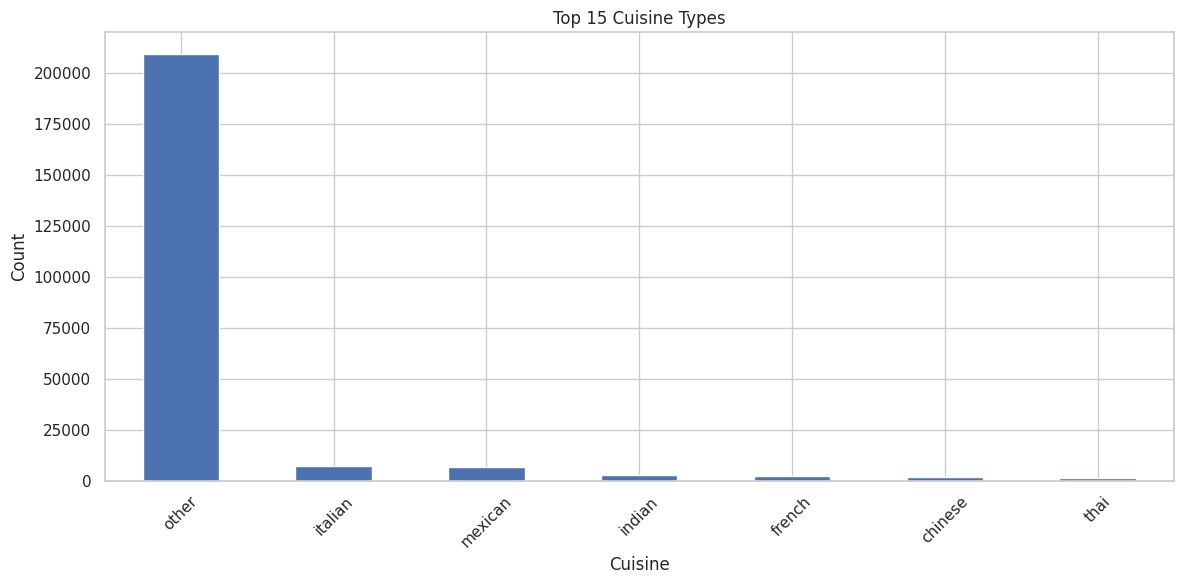

In [61]:
# # Distribution of cuisine types
plt.figure(figsize=(12, 6))
if 'cuisine_type' in recipes_df.columns:
    # Limit to top 15 cuisines to avoid cluttered plot
    recipes_df['cuisine_type'].value_counts().nlargest(15).plot(kind='bar')
    plt.title('Top 15 Cuisine Types')
    plt.xlabel('Cuisine')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [62]:
# # Distribution of cooking time - use smaller bins
# if 'cooking_time' in recipes_df.columns:
#     plt.figure(figsize=(10, 6))
#     # Use log scale for better visualization if the range is large
#     if recipes_df['cooking_time'].max() > 5 * recipes_df['cooking_time'].median():
#         sns.histplot(recipes_df['cooking_time'].clip(upper=recipes_df['cooking_time'].quantile(0.95)), bins=20)
#         plt.title('Distribution of Cooking Time (minutes) - Clipped at 95th percentile')
#     else:
#         sns.histplot(recipes_df['cooking_time'], bins=20)
#         plt.title('Distribution of Cooking Time (minutes)')
#     plt.xlabel('Cooking Time (minutes)')
#     plt.ylabel('Count')
#     plt.tight_layout()
#     plt.show()

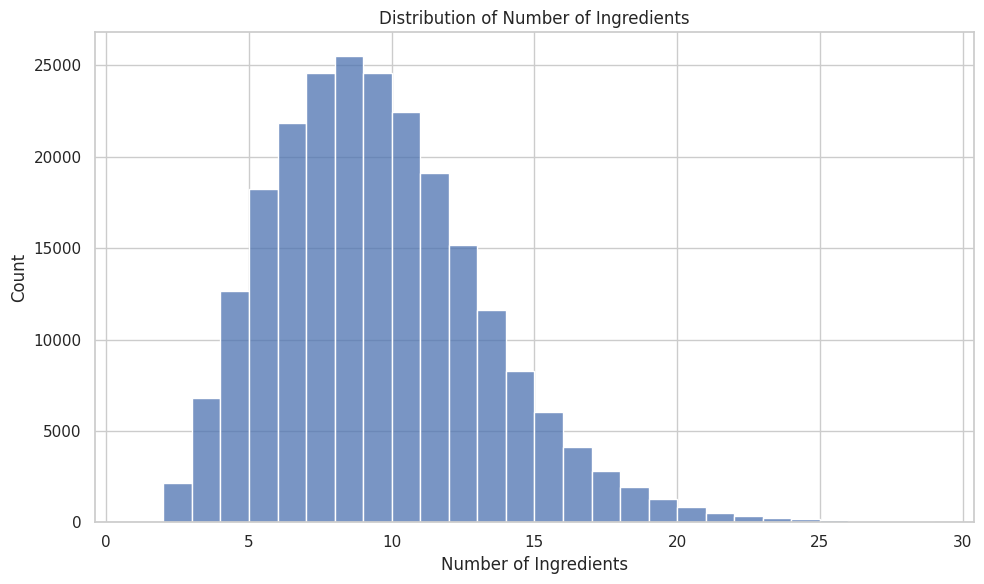

In [63]:
# Number of ingredients distribution
if 'n_ingredients' in recipes_df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(recipes_df['n_ingredients'], bins=range(1, min(30, recipes_df['n_ingredients'].max()+1)))
    plt.title('Distribution of Number of Ingredients')
    plt.xlabel('Number of Ingredients')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

## Data Cleaning and Preprocessing

Now we'll clean the data by:
1. Removing duplicate recipes
2. Normalizing ingredient names
3. Standardizing measurements
4. Handling missing values
5. Creating dietary tags

In [64]:

# Function to check and remove duplicates in dataframes
def check_remove_duplicates(df, df_name, subset_cols=None):
    """
    Check and remove duplicates from a dataframe.
    
    Args:
        df: The dataframe to process
        df_name: Name of the dataframe for printing
        subset_cols: List of columns to consider for duplicates. If None, all columns are used.
    
    Returns:
        Dataframe with duplicates removed
    """
    print(f"\n{'-' * 30}")
    print(f"Duplicate analysis for {df_name}:")
    print(f"{'-' * 30}")
    
    # If subset not specified, identify potential key columns
    if subset_cols is None:
        # Try to find ID-like columns first
        id_cols = [col for col in df.columns if 'id' in col.lower()]
        name_cols = [col for col in df.columns if 'name' in col.lower()]
        
        if id_cols:
            subset_cols = id_cols
            print(f"Using ID columns for duplicate check: {subset_cols}")
        elif name_cols:
            subset_cols = name_cols
            print(f"Using name columns for duplicate check: {subset_cols}")
        else:
            # Use all columns if no suitable identifiers found
            subset_cols = df.columns.tolist()
            print("Using all columns for duplicate check")
    
    # Check for duplicates
    dup_count = df.duplicated(subset=subset_cols).sum()
    print(f"Number of duplicates in {df_name}: {dup_count} ({dup_count/len(df):.2%} of data)")
    
    if dup_count > 0:
        # Remove duplicates
        df_cleaned = df.drop_duplicates(subset=subset_cols).reset_index(drop=True)
        print(f"Number of records after removing duplicates: {len(df_cleaned)}")
        return df_cleaned
    else:
        print("No duplicates found")
        return df


In [65]:
# Check and remove duplicates from all dataframes
print("\n=== DUPLICATE ANALYSIS FOR ALL DATAFRAMES ===")
recipes_df = check_remove_duplicates(recipes_df, "Recipes", subset_cols=['name'])
interactions_df = check_remove_duplicates(interactions_df, "Interactions")
nutrition_df = check_remove_duplicates(nutrition_df, "Nutrition")



=== DUPLICATE ANALYSIS FOR ALL DATAFRAMES ===

------------------------------
Duplicate analysis for Recipes:
------------------------------
Number of duplicates in Recipes: 1451 (0.63% of data)
Number of records after removing duplicates: 230186

------------------------------
Duplicate analysis for Interactions:
------------------------------
Using ID columns for duplicate check: ['user_id', 'recipe_id']
Number of duplicates in Interactions: 0 (0.00% of data)
No duplicates found

------------------------------
Duplicate analysis for Nutrition:
------------------------------
Using all columns for duplicate check
Number of duplicates in Nutrition: 0 (0.00% of data)
No duplicates found


In [66]:

# Function to normalize ingredient names
def normalize_ingredients(ingredient_list):
    """
    Normalize ingredient names by removing quantities and standardizing format
    """
    normalized = []
    # If ingredient_list is already a list of strings
    if isinstance(ingredient_list, list):
        for ingredient in ingredient_list:
            # Skip empty ingredients
            if not ingredient or not isinstance(ingredient, str):
                continue
            
            # Remove quantities (simplified for demonstration)
            cleaned = re.sub(r'^\d+\s+\d+/\d+\s+', '', ingredient)
            cleaned = re.sub(r'^\d+/\d+\s+', '', cleaned)
            cleaned = re.sub(r'^\d+\s+', '', cleaned)
            
            # Convert to lowercase and strip whitespace
            cleaned = cleaned.lower().strip()
            
            normalized.append(cleaned)
    else:
        # Handle the case where ingredient_list might be a string or another format
        print("Warning: Expected ingredient_list to be a list, but got:", type(ingredient_list))
        if isinstance(ingredient_list, str):
            # Try to interpret as a string representation of a list
            try:
                actual_list = eval(ingredient_list) if ingredient_list.startswith('[') else [ingredient_list]
                return normalize_ingredients(actual_list)
            except:
                normalized = [ingredient_list.lower().strip()]
    
    return normalized

# Apply normalization to ingredients - with error handling
recipes_df['normalized_ingredients'] = recipes_df['ingredients'].apply(
    lambda x: normalize_ingredients(x) if isinstance(x, list) or isinstance(x, str) else []
)

# Show a sample recipe with normalized ingredients
if len(recipes_df) > 0:
    sample_idx = 0
    print(f"Original ingredients: {recipes_df.iloc[sample_idx]['ingredients']}")
    print(f"Normalized ingredients: {recipes_df.iloc[sample_idx]['normalized_ingredients']}")
else:
    print("No recipes found in the dataframe.")

Original ingredients: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']
Normalized ingredients: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']


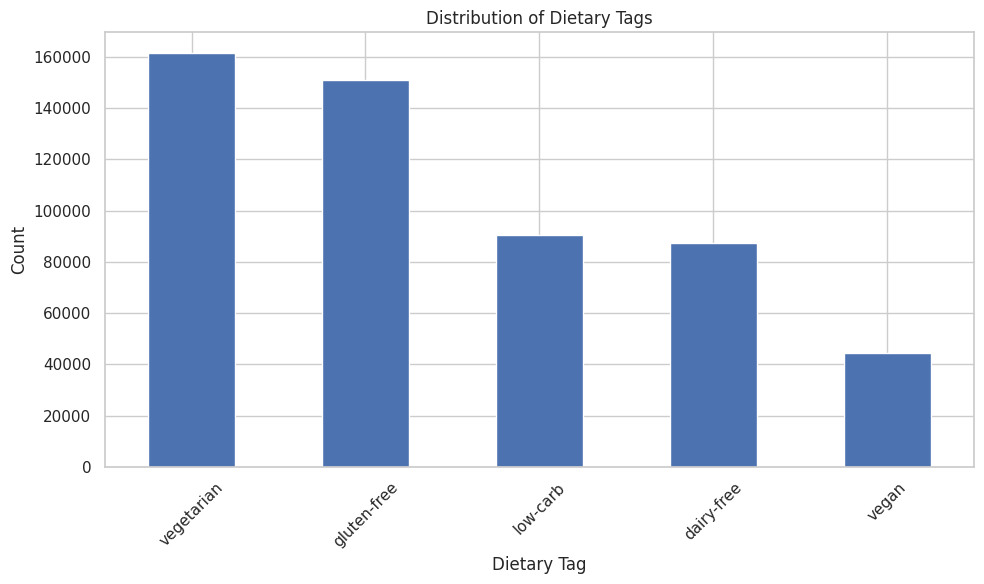


Sample recipes with dietary tags:

Recipe: hamburger and kd casserole
Ingredients: lean beef, macaroni & cheese dinner mix, cream of mushroom soup, peas, carrot, sour cream, garlic powder, salt, cheddar cheese, breadcrumbs
Dietary Tags: None

Recipe: banana drop cookies
Ingredients: flour, sugar, baking powder, baking soda, salt, shortening, eggs, banana, vanilla, cinnamon
Dietary Tags: vegetarian, dairy-free

Recipe: ground turkey and rice soup
Ingredients: ground turkey, rice, carrots, celery ribs, onion, bell pepper, green chilies, chicken stock, water, knorr chicken bouillon, pepper, season salt, cumin, chili powder, minced garlic clove
Dietary Tags: gluten-free, dairy-free

Recipe: cheeseburger and fry wrap
Ingredients: frozen french fries, oil, ground beef, onion, garlic clove, salt and pepper, shredded cheddar cheese, tortillas, lettuce, pickle, tomatoes, ketchup, mustard
Dietary Tags: gluten-free, low-carb

Recipe: grilled tandoori chicken ala mareesme
Ingredients: chicken qua

In [67]:
# Function to identify dietary tags based on ingredients
def identify_dietary_tags(ingredients):
    """
    Identify dietary preferences based on ingredients
    """
    # Handle empty ingredients list
    if not ingredients or not isinstance(ingredients, (list, str)):
        return []
        
    # Convert list of ingredients to a single string for easier checking
    ingredients_str = ' '.join(ingredients).lower()
    
    tags = []
    
    # Vegetarian check (simplified)
    meat_ingredients = ['chicken', 'beef', 'pork', 'lamb', 'turkey', 'veal', 'bacon']
    if not any(meat in ingredients_str for meat in meat_ingredients):
        tags.append('vegetarian')
        
        # Vegan check (simplified)
        animal_products = ['cheese', 'milk', 'cream', 'yogurt', 'butter', 'egg', 'honey']
        if not any(product in ingredients_str for product in animal_products):
            tags.append('vegan')
    
    # Gluten-free check (simplified)
    gluten_ingredients = ['flour', 'wheat', 'barley', 'rye', 'pasta', 'bread']
    if not any(gluten in ingredients_str for gluten in gluten_ingredients):
        tags.append('gluten-free')
    
    # Low-carb check (simplified)
    high_carb_ingredients = ['sugar', 'pasta', 'rice', 'potato', 'bread', 'flour']
    if not any(carb in ingredients_str for carb in high_carb_ingredients):
        tags.append('low-carb')
    
    # Dairy-free check
    dairy_ingredients = ['milk', 'cheese', 'cream', 'yogurt', 'butter']
    if not any(dairy in ingredients_str for dairy in dairy_ingredients):
        tags.append('dairy-free')
    
    return tags

# Apply dietary tagging
recipes_df['dietary_tags'] = recipes_df['normalized_ingredients'].apply(identify_dietary_tags)

# Show the distribution of dietary tags
diet_counts = {}
for tags in recipes_df['dietary_tags']:
    for tag in tags:
        diet_counts[tag] = diet_counts.get(tag, 0) + 1

plt.figure(figsize=(10, 6))
diet_df = pd.Series(diet_counts).sort_values(ascending=False)
diet_df.plot(kind='bar')
plt.title('Distribution of Dietary Tags')
plt.xlabel('Dietary Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show sample recipes with their dietary tags
print("\nSample recipes with dietary tags:")
sample_recipes = recipes_df[['name', 'normalized_ingredients', 'dietary_tags']].sample(5)
for _, recipe in sample_recipes.iterrows():
    print(f"\nRecipe: {recipe['name']}")
    print(f"Ingredients: {', '.join(recipe['normalized_ingredients'])}")
    print(f"Dietary Tags: {', '.join(recipe['dietary_tags']) if recipe['dietary_tags'] else 'None'}")

In [68]:

# Basic dataset information
print("Raw Datasets information:")
print(f"Number of recipes: {len(recipes_df)}")
print("\nrecipes_df columns:")
print(recipes_df.columns.tolist())
print(15 * "-")
print(f"Number of interactions: {len(interactions_df)}")
print("\ninteractions_df columns:")
print(interactions_df.columns.tolist())
print(15 * "-")
print(f"Number of nutritions: {len(nutrition_df)}")
print("\nnutrition_df columns:")
print(nutrition_df.columns.tolist())
print(15 * "-")


Raw Datasets information:
Number of recipes: 230186

recipes_df columns:
['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients', 'cuisine_type', 'normalized_ingredients', 'dietary_tags']
---------------
Number of interactions: 1132367

interactions_df columns:
['user_id', 'recipe_id', 'date', 'rating', 'review']
---------------
Number of nutritions: 3454

nutrition_df columns:
['Vitamin C', 'Vitamin B11', 'Sodium', 'Calcium', 'Carbohydrates', 'food', 'Iron', 'Caloric Value', 'Sugars', 'Dietary Fiber', 'Fat', 'Protein', 'food_normalized']
---------------


## Final Data Structure and Storage

### Save Datasets in JSON Format for RAG Implementation

Let's save each dataset in JSON format to facilitate their use in our Retrieval Augmented Generation (RAG) system. JSON format is highly compatible with various RAG implementations and will make it easier to load the data in subsequent steps.

In [69]:
import chromadb
print(chromadb.__version__)


0.6.3


In [70]:


# Define paths for ChromaDB and SQL database
VECTOR_DB_PATH = "final/vector_db"
DB_PATH = "final/kitchen_db.sqlite"

#####################
# SQL Database Setup
#####################
def safe_convert(x):
    """
    Safely converts a value to a string:
      - If x is a list or numpy array, join its elements into a space-separated string.
      - If x is not a list/array and is not null, convert to string.
      - Otherwise, return an empty string.
    """
    if isinstance(x, (list, np.ndarray)):
        return " ".join([str(item) for item in x])
    return str(x) if pd.notna(x) else ""


def preprocess_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess DataFrame columns to be SQLite-compatible.
    """
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(safe_convert)
    return df

def setup_sql_database(
    recipes_df: pd.DataFrame, 
    interactions_df: pd.DataFrame, 
    nutrition_df: Optional[pd.DataFrame] = None,
    db_path: str = DB_PATH
) -> sqlite3.Connection:
    """
    Set up SQLite database with raw dataframes.
    """
    recipes_df = preprocess_dataframe(recipes_df)
    interactions_df = preprocess_dataframe(interactions_df)
    if nutrition_df is not None:
        nutrition_df = preprocess_dataframe(nutrition_df)

    os.makedirs(os.path.dirname(db_path), exist_ok=True)
    print(f"Creating SQLite database at {db_path}")
    conn = sqlite3.connect(db_path)
    
    print(f"Storing {len(recipes_df)} recipes in the database")
    recipes_df.to_sql('recipes', conn, if_exists='replace', index=False)
    print(f"Storing {len(interactions_df)} interactions in the database")
    interactions_df.to_sql('interactions', conn, if_exists='replace', index=False)
    
    if nutrition_df is not None:
        print(f"Storing {len(nutrition_df)} nutrition entries in the database")
        nutrition_df.to_sql('nutrition', conn, if_exists='replace', index=False)
    
    print("SQL database setup complete")
    return conn

#############################
# Vector Database Setup (ChromaDB)
#############################
def setup_vector_database(
    vectorized_recipes_df: pd.DataFrame,
    vectorized_interactions_df: Optional[pd.DataFrame] = None,
    vector_db_path: str = VECTOR_DB_PATH
) -> Tuple[Any, Any, Optional[Any]]:
    """
    Set up ChromaDB using the precomputed dataframes for recipes and interactions.
    
    Arguments:
        vectorized_recipes_df: DataFrame with your recipe data.
        vectorized_interactions_df: DataFrame with your interaction data.
        vector_db_path: Directory where ChromaDB will store its data.
        
    Returns:
        A tuple containing the ChromaDB client, the recipe collection, and 
        the interactions collection (if interactions_df is provided).
    """
    os.makedirs(vector_db_path, exist_ok=True)
    print(f"Creating ChromaDB at {vector_db_path}")
    client = chromadb.PersistentClient(path=vector_db_path)
    
    #########################
    # Load recipes into ChromaDB
    #########################
    print(f"Setting up recipe collection with {len(vectorized_recipes_df)} recipes")
    recipe_collection = client.get_or_create_collection(name="recipes")
    
    recipe_documents = []
    recipe_metadatas = []
    recipe_ids = []
    
    # Define which recipe columns to include as metadata
    metadata_fields = ['name', 'minutes', 'contributor_id', 'submitted',
                       'tags', 'nutrition', 'n_steps', 'cuisine_type',
                       'n_ingredients', 'dietary_tags']
    
    for i, row in vectorized_recipes_df.iterrows():
        # Determine a unique recipe ID. Use 'id' column if available.
        recipe_id = row.get('id')
        if recipe_id is None or (isinstance(recipe_id, float) and pd.isna(recipe_id)) or recipe_id == "":
            recipe_id = str(i)
        else:
            recipe_id = str(recipe_id)
        recipe_ids.append(recipe_id)
        
        # Build a document string by concatenating key text fields.
        # You may adjust the fields below to better capture recipe information.
        doc_text = " ".join([
            safe_convert(row.get('name', '')),
            safe_convert(row.get('ingredients', '')),
            safe_convert(row.get('steps', '')),
            safe_convert(row.get('description', ''))
        ])
        recipe_documents.append(doc_text)
        
        # Build richer metadata from the chosen fields.
        metadata = {key: safe_convert(row.get(key, "")) for key in metadata_fields}
        metadata['recipe_id'] = recipe_id
        recipe_metadatas.append(metadata)
    
    batch_size = 1000
    for j in range(0, len(recipe_documents), batch_size):
        end_idx = min(j + batch_size, len(recipe_documents))
        recipe_collection.add(
            documents=recipe_documents[j:end_idx],
            metadatas=recipe_metadatas[j:end_idx],
            ids=recipe_ids[j:end_idx]
        )
    
    #########################
    # Load interactions into ChromaDB (if provided)
    #########################
    interactions_collection = None
    if vectorized_interactions_df is not None and not vectorized_interactions_df.empty:
        print(f"Setting up interactions collection with {len(vectorized_interactions_df)} interactions")
        interactions_collection = client.get_or_create_collection(name="interactions")
        
        interaction_documents = []
        interaction_metadatas = []
        interaction_ids = []
        
        for i, row in vectorized_interactions_df.iterrows():
            # Create a unique interaction ID from user_id, recipe_id, and index.
            user_id = safe_convert(row.get('user_id', ''))
            recipe_id = safe_convert(row.get('recipe_id', ''))
            interaction_id = f"{user_id}_{recipe_id}_{i}"
            interaction_ids.append(interaction_id)
            
            # Use the review text as the primary document.
            review_text = safe_convert(row.get('review', ''))
            if not review_text:
                review_text = "No review provided."
            interaction_documents.append(review_text)
            
            # Build metadata for this interaction.
            int_metadata = {
                'interaction_id': interaction_id,
                'user_id': user_id,
                'recipe_id': recipe_id,
                'date': safe_convert(row.get('date', '')),
                'rating': safe_convert(row.get('rating', ''))
            }
            interaction_metadatas.append(int_metadata)
        
        for j in range(0, len(interaction_documents), batch_size):
            end_idx = min(j + batch_size, len(interaction_documents))
            interactions_collection.add(
                documents=interaction_documents[j:end_idx],
                metadatas=interaction_metadatas[j:end_idx],
                ids=interaction_ids[j:end_idx]
            )
    
    print("Vector database setup complete")
    return client, recipe_collection, interactions_collection




In [71]:
##############################
# Main Execution
##############################
if __name__ == "__main__":
    # Assume recipes_df and interactions_df have been loaded previously.
    # For example:
    # recipes_df = pd.read_pickle("your_recipes.pkl")
    # interactions_df = pd.read_pickle("your_interactions.pkl")

    # Set up the SQL database
    # sqlite_conn = setup_sql_database(
    #     recipes_df=recipes_df,
    #     interactions_df=interactions_df,
    #     nutrition_df=nutrition_df,  # Modify if you have nutrition data.
    #     db_path=DB_PATH
    # )
    
    # Set up ChromaDB with recipes and interactions
    # chroma_client, recipe_collection, interactions_collection = setup_vector_database(
    #     vectorized_recipes_df=recipes_df,
    #     vectorized_interactions_df=interactions_df,
    #     vector_db_path=VECTOR_DB_PATH
    # )
    
    print("ChromaDB is ready for similarity search!")

ChromaDB is ready for similarity search!


In [72]:

# Path to SQL database
DB_PATH = "final/kitchen_db.sqlite"
# Path to Vectorized database
VECTOR_DB_PATH = "final/vector_db"


def view_schema_info(collection_name: str, db_path: str = VECTOR_DB_PATH):
    """
    View schema information for a collection (metadata fields and their data types).
    
    Args:
        collection_name: Name of the collection to analyze
        db_path: Path to the ChromaDB database
    """
    client = chromadb.PersistentClient(path=db_path)
    
    try:
        collection = client.get_collection(name=collection_name)
    except ValueError as e:
        print(f"Collection '{collection_name}' not found. Error: {str(e)}")
        return None
    
    # Get a sample of records to analyze schema
    try:
        results = collection.get(
            limit=100,
            include=['metadatas']
        )
        
        if not results['metadatas']:
            print(f"Collection '{collection_name}' is empty or has no metadata.")
            return None
        
        # Analyze metadata fields
        print(f"\n=== Schema for '{collection_name}' collection ===\n")
        print("Metadata fields:")
        
        # Collect all possible keys and their types
        all_keys = set()
        key_types = {}
        key_examples = {}
        
        for metadata in results['metadatas']:
            for key, value in metadata.items():
                all_keys.add(key)
                
                # Track the data type
                value_type = type(value).__name__
                if key not in key_types:
                    key_types[key] = set()
                key_types[key].add(value_type)
                
                # Store an example value
                if key not in key_examples and value:
                    example = str(value)
                    if len(example) > 50:
                        example = example[:50] + "..."
                    key_examples[key] = example
        
        # Display the schema information
        for key in sorted(all_keys):
            types_str = ", ".join(key_types[key])
            example = key_examples.get(key, "N/A")
            print(f"  - {key}: {types_str}")
            print(f"    Example: {example}")
        
        return key_types
    
    except Exception as e:
        print(f"Error getting schema info: {str(e)}")
        return None


def collection_info(db_path: str = VECTOR_DB_PATH):
    """
    A simple function to display basic information about all collections.
    More robust against API changes than the other functions.
    
    Args:
        db_path: Path to the ChromaDB database
    """
    client = chromadb.PersistentClient(path=db_path)
    
    try:
        collection_names = client.list_collections()
        print(f"Found {len(collection_names)} collections in {db_path}:")
        
        for name in collection_names:
            print(f"\nCollection: {name}")
            
            try:
                collection = client.get_collection(name=str(name))
                
                # Try to get count
                try:
                    count = collection.count(where={})
                    print(f"  Records: {count}")
                except:
                    print("  Count: Could not retrieve")
                
                # Try to get the first few items
                try:
                    first_items = collection.get(limit=3, include=["metadatas"])
                    print(f"  Sample IDs: {first_items['ids']}")
                    
                    # Show first item metadata as example
                    if first_items['metadatas'] and len(first_items['metadatas']) > 0:
                        print("  Sample metadata keys:", list(first_items['metadatas'][0].keys()))
                except:
                    print("  Sample: Could not retrieve")
                    
            except Exception as e:
                print(f"  Error accessing collection: {str(e)}")
        
    except Exception as e:
        print(f"Error listing collections: {str(e)}")


In [73]:
client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
print(client.list_collections())

['interactions', 'recipes']


In [74]:
collection_info(VECTOR_DB_PATH)

Found 2 collections in final/vector_db:

Collection: interactions
  Count: Could not retrieve
  Sample IDs: ['38094_40893_0', '1293707_40893_1', '8937_44394_2']
  Sample metadata keys: ['date', 'interaction_id', 'rating', 'recipe_id', 'user_id']

Collection: recipes
  Count: Could not retrieve
  Sample IDs: ['137739', '31490', '112140']
  Sample metadata keys: ['contributor_id', 'cuisine_type', 'dietary_tags', 'minutes', 'n_ingredients', 'n_steps', 'name', 'nutrition', 'recipe_id', 'submitted', 'tags']


In [75]:
view_schema_info("recipes", VECTOR_DB_PATH)


=== Schema for 'recipes' collection ===

Metadata fields:
  - contributor_id: str
    Example: 47892
  - cuisine_type: str
    Example: mexican
  - dietary_tags: str
    Example: vegetarian gluten-free low-carb
  - minutes: str
    Example: 55
  - n_ingredients: str
    Example: 7
  - n_steps: str
    Example: 11
  - name: str
    Example: arriba   baked winter squash mexican style
  - nutrition: str
    Example: [51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]
  - recipe_id: str
    Example: 137739
  - submitted: str
    Example: 2005-09-16
  - tags: str
    Example: 60-minutes-or-less time-to-make course main-ingred...


{'contributor_id': {'str'},
 'cuisine_type': {'str'},
 'dietary_tags': {'str'},
 'minutes': {'str'},
 'n_ingredients': {'str'},
 'n_steps': {'str'},
 'name': {'str'},
 'nutrition': {'str'},
 'recipe_id': {'str'},
 'submitted': {'str'},
 'tags': {'str'}}

In [76]:
view_schema_info("interactions", VECTOR_DB_PATH)


=== Schema for 'interactions' collection ===

Metadata fields:
  - date: str
    Example: 2003-02-17
  - interaction_id: str
    Example: 38094_40893_0
  - rating: str
    Example: 4
  - recipe_id: str
    Example: 40893
  - user_id: str
    Example: 38094


{'date': {'str'},
 'interaction_id': {'str'},
 'rating': {'str'},
 'recipe_id': {'str'},
 'user_id': {'str'}}

In [77]:

def gemini_recipe_similarity_search(query_text: str, n_results: int, cuisine: Optional[str] = None, dietary_tag: Optional[str] = None, max_minutes: Optional[int] = None) -> str:
    """
    Searches for similar recipes based on a query, with optional filters and returns full metadata.

    Args:
        query_text: The text to search for in recipes.
        n_results: The number of top similar recipes to return.
        cuisine: (Optional) Filter by cuisine type (e.g., 'mexican', 'italian').
        dietary_tag: (Optional) Filter by dietary tag (e.g., 'vegetarian', 'gluten-free').
        max_minutes: (Optional) Filter recipes with a cooking time less than or equal to this value.

    Returns:
        A formatted string containing the full metadata of the top similar recipes with similarity scores.
    """
    try:
        client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
        recipe_collection = client.get_collection(name="recipes")

        where_clause = {}
        if cuisine is not None:
            where_clause["cuisine_type"] = cuisine
        if dietary_tag is not None:
            where_clause["dietary_tags"] = {"$contains": dietary_tag}
        if max_minutes is not None:
            where_clause["minutes"] = {"$lte": str(max_minutes)} # Store as string in metadata

        results = recipe_collection.query(
            query_texts=[query_text],
            n_results=n_results,
            include=["documents", "metadatas", "distances"]
        )

        if not results['ids'][0]:
            return f"No similar recipes found for the query: '{query_text}' with the specified criteria."

        output = f"Found {len(results['ids'][0])} similar recipes for query: '{query_text}'.\n"
        output += "-" * 80 + "\n"
        for i, (doc_id, doc, metadata, distance) in enumerate(zip(
            results['ids'][0],
            results['documents'][0],
            results['metadatas'][0],
            results['distances'][0]
        )):
            similarity_score = (1 - distance) * 100
            output += f"\n{i+1}. Recipe Name: {metadata.get('name', 'Unnamed')}\n"
            output += f"   Similarity: {similarity_score:.2f}%\n"
            output += f"   Recipe ID: {doc_id}\n"
            for key, value in metadata.items():
                output += f"   {key.replace('_', ' ').title()}: {value}\n"
            output += f"   Ingredients: {doc}\n"  # Include the full document (ingredients/steps)
            output += "-" * 80 + "\n"

        return output

    except Exception as e:
        return f"Error during recipe similarity search: {e}"

# Updated `gemini_interaction_similarity_search` Function:

def gemini_interaction_similarity_search(query_text: str, n_results: int) -> str:
    """
    Searches for similar user interactions (reviews) based on a query and returns full metadata.

    Args:
        query_text: The text to search for in user reviews.
        n_results: The number of top similar interactions to return.

    Returns:
        A formatted string containing the full metadata of the top similar interactions with similarity scores.
    """
    try:
        client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
        interactions_collection = client.get_collection(name="interactions")
        results = interactions_collection.query(
            query_texts=[query_text],
            n_results=n_results,
            include=["documents", "metadatas", "distances"]
        )

        if not results['ids'][0]:
            return f"No similar reviews found for the query: '{query_text}'."

        output = f"Found {len(results['ids'][0])} similar reviews for query: '{query_text}'.\n"
        output += "-" * 80 + "\n"
        for i, (doc_id, doc, metadata, distance) in enumerate(zip(
            results['ids'][0],
            results['documents'][0],
            results['metadatas'][0],
            results['distances'][0]
        )):
            similarity_score = (1 - distance) * 100
            output += f"\n{i+1}. Review ID: {doc_id}\n"
            output += f"   Similarity: {similarity_score:.2f}%\n"
            for key, value in metadata.items():
                output += f"   {key.replace('_', ' ').title()}: {value}\n"
            output += f"   Review Text: {doc}\n"  # Include the full document (review text)
            output += "-" * 80 + "\n"

        return output

    except ValueError:
        return "Interactions collection not found. Make sure you have interaction data loaded."
    except Exception as e:
        return f"Error during interaction similarity search: {e}"

In [78]:
query_text = "check for making an italian pizza "
result = gemini_recipe_similarity_search(query_text, n_results = 1)
print(result)

Found 1 similar recipes for query: 'check for making an italian pizza '.
--------------------------------------------------------------------------------

1. Recipe Name: gluten free and low fat vegetarian pizza
   Similarity: 39.87%
   Recipe ID: 455493
   Contributor Id: 286566
   Cuisine Type: other
   Dietary Tags: vegetarian vegan dairy-free
   Minutes: 30
   N Ingredients: 11
   N Steps: 9
   Name: gluten free and low fat vegetarian pizza
   Nutrition: [234.7, 21.0, 30.0, 28.0, 25.0, 33.0, 5.0]
   Recipe Id: 455493
   Submitted: 2011-05-09
   Tags: 30-minutes-or-less time-to-make course main-ingredient preparation main-dish vegetables pizza dietary gluten-free mushrooms free-of-something peppers artichoke
   Ingredients: gluten free and low fat vegetarian pizza bread mix cold water garlic cloves fresh rosemary pasta sauce red capsicum artichoke heart button mushrooms kalamata olive bocconcini rocket preheat oven to 240c lightly grease two 18cm pizza trays place bread mix in a bow

In [79]:
query_text = "best italian pizza"
result = gemini_interaction_similarity_search(query_text, n_results = 1)
print(result)

Found 1 similar reviews for query: 'best italian pizza'.
--------------------------------------------------------------------------------

1. Review ID: 362880_165360_692272
   Similarity: 46.85%
   Date: 2006-12-15
   Interaction Id: 362880_165360_692272
   Rating: 5
   Recipe Id: 165360
   User Id: 362880
   Review Text: I made this for my Mom's birthday today--I wanted the pizza to be as Italian as possible (my Dad and I spent three weeks in Italy this Jan.) so I did a search here for thin-crust pizza and this was at the top of the list--BRAVO!

I made my own tomato sauce and topped it w/ a sprinkling of mozzarella cheese (unlike here in Canada and the States, the Italians only put enough cheese to lightly cover it--unless it's 4-cheese) and fresh basil--deeeeeelish!
--------------------------------------------------------------------------------



In [106]:
import sqlite3
import os
import requests
import json
import time # <--- Add this import
import random # <--- Add this import for jitter
from typing import List, Tuple, Optional, Dict

# Assume DB_PATH is defined elsewhere
# DB_PATH = "your_database_path.db"

# --- Database Functions (Mostly unchanged, added try/finally and context managers) ---

def list_tables() -> List[str]:
    """List all tables in the SQLite database using context managers."""
    tables = []
    try:
        with sqlite3.connect(DB_PATH) as conn:
            cursor = conn.cursor()
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
            tables = [table[0] for table in cursor.fetchall()]
    except sqlite3.Error as e:
        print(f"Error listing tables: {e}")
        # Depending on desired behavior, you might return [] or raise e
    return tables

def describe_table(table_name: str) -> List[Tuple[str, str]]:
    """Describe the schema of a specified table using context managers."""
    schema = []
    try:
        # Basic validation/sanitization - prevent SQL injection in table names
        if not table_name.isalnum() and '_' not in table_name:
             print(f"Warning: Invalid table name format '{table_name}'. Skipping.")
             return []
        with sqlite3.connect(DB_PATH) as conn:
            cursor = conn.cursor()
            # Use parameterized query even for PRAGMA if possible, or ensure table_name is safe
            # For PRAGMA table_info, direct insertion is common but requires validation ^
            cursor.execute(f"PRAGMA table_info({table_name});")
            schema_raw = cursor.fetchall()
            # Extract relevant columns (name, type) - indices 1 and 2
            schema = [(col[1], col[2]) for col in schema_raw]
    except sqlite3.Error as e:
        print(f"Error describing table '{table_name}': {e}")
    return schema


def execute_query(sql: str) -> List[Tuple]:
    """Execute a potentially read-only SQL query and return the results using context managers."""
    results = []
    # Basic check to prevent obviously harmful commands - enhance as needed
    if not sql.strip().upper().startswith("SELECT") and not sql.strip().upper().startswith("PRAGMA"):
         print("Warning: Only SELECT and PRAGMA queries are recommended via execute_query.")
         # return [("Error:", "Potentially unsafe query blocked.")] # Or allow if you trust the source
    try:
        with sqlite3.connect(DB_PATH) as conn:
            cursor = conn.cursor()
            cursor.execute(sql)
            results = cursor.fetchall()
    except sqlite3.Error as e:
        print(f"Error executing SQL query: {e}")
        # Return error message structured like results for consistency
        return [("Error executing SQL query:", str(e))]
    return results

# --- Modified Open Food Facts Function with Retries ---

def fetch_nutrition_from_openfoodfacts(ingredient_name: str) -> Dict:
    """
    Fetch nutrition data for an ingredient from Open Food Facts API.
    Includes retry logic for rate limiting (429) and transient errors.
    """
    api_key = os.getenv('OPENFOODFACTS_API_KEY')
    # You might still want a warning if the key isn't set, but OFF search often works without it.

    search_url = "https://world.openfoodfacts.org/cgi/search.pl"
    params = {
        "search_terms": ingredient_name,
        "search_simple": 1,
        "action": "process",
        "json": 1,
        "page_size": 1 # We only need the top result
    }
    headers = {'User-Agent': 'CapstoneProject/1.0 (Language Model Integration)'} # Good practice

    max_retries = 3 # Internal retry limit
    base_timeout = 15 # Internal timeout
    retry_delay = 1 # Initial delay in seconds for retries

    for attempt in range(max_retries):
        try:
            response = requests.get(search_url, params=params, headers=headers, timeout=base_timeout)
            response.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)

            data = response.json()

            if data.get('products') and len(data['products']) > 0:
                product = data['products'][0]
                nutriments = product.get('nutriments', {})

                nutrition_info = {
                    "food_normalized": ingredient_name,
                    "source": "Open Food Facts",
                    "product_name": product.get('product_name', 'N/A'),
                    "calories_100g": nutriments.get('energy-kcal_100g'),
                    "fat_100g": nutriments.get('fat_100g'),
                    "saturated_fat_100g": nutriments.get('saturated-fat_100g'),
                    "carbohydrates_100g": nutriments.get('carbohydrates_100g'),
                    "sugars_100g": nutriments.get('sugars_100g'),
                    "fiber_100g": nutriments.get('fiber_100g'),
                    "proteins_100g": nutriments.get('proteins_100g'),
                    "sodium_100g": nutriments.get('sodium_100g'),
                }
                return {k: v for k, v in nutrition_info.items() if v is not None}
            else:
                # No product found, not an error, just unavailable
                return {"status": "unavailable", "reason": f"No product found for '{ingredient_name}' on Open Food Facts"}

        except requests.exceptions.HTTPError as e:
            # Specific handling for Rate Limiting (429)
            if e.response.status_code == 429:
                if attempt < max_retries - 1:
                    # Exponential backoff with jitter
                    wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                    print(f"Rate limit hit for '{ingredient_name}'. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                    time.sleep(wait_time)
                    continue # Retry the loop
                else:
                    print(f"Rate limit hit for '{ingredient_name}'. Max retries exceeded.")
                    return {"status": "unavailable", "reason": f"API rate limit exceeded after {max_retries} attempts: {e}"}
            # Handle other HTTP errors (e.g., 5xx server errors) potentially with retries too
            elif e.response.status_code >= 500 and attempt < max_retries - 1:
                 wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                 print(f"Server error ({e.response.status_code}) for '{ingredient_name}'. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                 time.sleep(wait_time)
                 continue # Retry the loop
            else:
                # For other client errors (4xx) or server errors after retries, report failure
                print(f"HTTP Error fetching nutrition for '{ingredient_name}': {e}")
                return {"status": "unavailable", "reason": f"API request failed with HTTP error: {e}"}

        except requests.exceptions.RequestException as e:
            # Handle other connection/timeout errors
            if attempt < max_retries - 1:
                wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                print(f"Request error for '{ingredient_name}': {e}. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                time.sleep(wait_time)
                continue # Retry the loop
            else:
                print(f"Error fetching nutrition for '{ingredient_name}' after {max_retries} attempts: {e}")
                return {"status": "unavailable", "reason": f"API request failed after retries: {e}"}

        except json.JSONDecodeError:
            # If response is not valid JSON
            print(f"Error decoding JSON response for '{ingredient_name}'")
            # No retry for decoding error usually, indicates bad response content
            return {"status": "unavailable", "reason": "Invalid JSON response from API"}

    # Should not be reached if loop completes, but as a fallback:
    return {"status": "unavailable", "reason": "Max retries exceeded without success"}


# --- Modified Recipe Function with Small Delay ---

def get_recipe_by_id(recipe_id: str) -> Optional[dict]:
    """Get a recipe by its ID, including live nutrition data (with delays & retries)."""
    recipe = None
    try:
        with sqlite3.connect(DB_PATH) as conn:
            conn.row_factory = sqlite3.Row # Return rows that act like dictionaries
            cursor = conn.cursor()

            cursor.execute("SELECT * FROM recipes WHERE id = ?", (recipe_id,))
            recipe_data = cursor.fetchone()

            if not recipe_data:
                return None

            # Convert Row object to a mutable dictionary
            recipe = dict(recipe_data)

            # --- Field Parsing Logic (Keep your existing logic, maybe add more logging) ---
            for field in ["steps", "ingredients", "nutrition", "tags", "dietary_tags", "normalized_ingredients"]:
                value = recipe.get(field)
                if isinstance(value, str):
                    try:
                        recipe[field] = json.loads(value)
                        # print(f"Successfully parsed JSON for field '{field}' in recipe ID {recipe_id}.") # Optional: Success log
                    except json.JSONDecodeError:
                        if field in ["ingredients", "tags", "dietary_tags", "normalized_ingredients"]:
                            # Fallback: Split potentially space or comma-separated strings
                            # Consider more robust splitting if needed (e.g., handle commas)
                            potential_list = [item.strip() for item in value.replace(',', ' ').split() if item.strip()]
                            if potential_list:
                                recipe[field] = potential_list
                                print(f"Info: Field '{field}' in recipe ID {recipe_id} treated as separated string -> {recipe[field]}")
                            else:
                                print(f"Warning: Field '{field}' in recipe ID {recipe_id} was string but empty after split.")
                                recipe[field] = [] # Ensure it's an empty list
                        elif field == "steps":
                            print(f"Warning: Could not parse JSON for field 'steps' in recipe ID {recipe_id}. Kept as string.")
                            # Keep as string is fine here
                        else: # E.g., nutrition field if not JSON
                            print(f"Warning: Could not parse JSON for field '{field}' in recipe ID {recipe_id}. Value: {value[:100]}...")
                            # Decide how to handle - keep string, set to None, etc.
                            pass
                # Ensure expected list fields are indeed lists if they exist but aren't strings
                elif field in ["ingredients", "tags", "dietary_tags", "normalized_ingredients"] and value is not None and not isinstance(value, list):
                     print(f"Warning: Field '{field}' in recipe ID {recipe_id} was type {type(value)}, expected list or string. Attempting conversion.")
                     try:
                         recipe[field] = list(value) # Basic conversion attempt
                     except TypeError:
                         print(f"Error: Could not convert field '{field}' to list for recipe ID {recipe_id}. Setting to empty list.")
                         recipe[field] = []


            # --- Fetch nutrition for normalized ingredients ---
            ingredient_nutrition_list = []
            normalized_ingredients = recipe.get("normalized_ingredients")

            if isinstance(normalized_ingredients, list):
                for i, ingredient in enumerate(normalized_ingredients):
                    if isinstance(ingredient, str) and ingredient.strip():
                        print(f"Fetching nutrition for: '{ingredient}' (Item {i+1}/{len(normalized_ingredients)})") # Log progress
                        nutrition_data = fetch_nutrition_from_openfoodfacts(ingredient)
                        ingredient_nutrition_list.append(nutrition_data)
                        # *** ADD A SMALL DELAY HERE ***
                        time.sleep(random.uniform(0.5, 1.5)) # Wait 0.5 to 1.5 seconds before the next call
                    elif not isinstance(ingredient, str):
                         print(f"Warning: Skipping non-string item in normalized_ingredients: {ingredient}")
                         ingredient_nutrition_list.append({"status": "skipped", "reason": f"Invalid ingredient format: {type(ingredient)}"})
                    # else: skip empty strings silently
            elif normalized_ingredients is not None:
                print(f"Error: 'normalized_ingredients' field in recipe ID {recipe_id} is not a list after processing. Type: {type(normalized_ingredients)}")
                ingredient_nutrition_list.append({"status": "error", "reason": "normalized_ingredients field could not be processed into a list"})

            recipe['ingredient_nutrition'] = ingredient_nutrition_list

    except sqlite3.Error as e:
        print(f"Database error getting recipe ID {recipe_id}: {e}")
        return None # Or raise the error if preferred
    except Exception as e: # Catch other potential errors
        print(f"An unexpected error occurred in get_recipe_by_id for {recipe_id}: {e}")
        # Return the partially processed recipe if available, or None
        return recipe if recipe else None

    return recipe


# --- Ratings Function (Using context manager) ---
def get_ratings_and_reviews_by_recipe_id(recipe_id: str, limit: int) -> Optional[dict]:
    """Get ratings and recent reviews for a recipe ID using context managers."""
    overall_rating = None
    reviews_list = []
    try:
        with sqlite3.connect(DB_PATH) as conn:
            cursor = conn.cursor()
            # Get overall rating
            cursor.execute("SELECT AVG(rating) FROM interactions WHERE recipe_id = ?", (recipe_id,))
            overall_rating_result = cursor.fetchone()
            # Ensure we handle None if no ratings exist before accessing index 0
            if overall_rating_result and overall_rating_result[0] is not None:
                 overall_rating = round(overall_rating_result[0], 2) # Round for cleaner display


            # Get most recent reviews
            cursor.execute(
                "SELECT date, rating, review FROM interactions WHERE recipe_id = ? AND review IS NOT NULL AND review != '' ORDER BY date DESC LIMIT ?",
                (recipe_id, limit),
            )
            recent_reviews = cursor.fetchall()
            columns = ["date", "rating", "review"]
            reviews_list = [dict(zip(columns, review)) for review in recent_reviews]

    except sqlite3.Error as e:
        print(f"Database error getting ratings/reviews for recipe ID {recipe_id}: {e}")
        # Return partial data or indicate error
        return {"overall_rating": overall_rating, "recent_reviews": [], "error": str(e)}

    return {"overall_rating": overall_rating, "recent_reviews": reviews_list}

In [ ]:
import requests
import json
import time
import random
import os # Added to potentially get API key from environment

# Consider getting the API key from an environment variable for security
# Example: export USDA_API_KEY='YOUR_API_KEY_HERE'
# If using an environment variable:
# USDA_API_KEY = os.environ.get("USDA_API_KEY")
# Or pass it directly as an argument to the function.

# Mapping from FDC nutrient names (or IDs for more stability) to our desired keys.
# Using names here for readability. Units are typically per 100g in FDC.
# Note: FDC uses 'KCAL' for calories, 'G' for macros, 'MG' for sodium.
FDC_NUTRIENT_MAP = {
    # Nutrient Name in FDC API : Target Key
    "Energy": "calories_100g", # Often unit KCAL
    "Total lipid (fat)": "fat_100g", # Often unit G
    "Fatty acids, total saturated": "saturated_fat_100g", # Often unit G
    "Carbohydrate, by difference": "carbohydrates_100g", # Often unit G
    "Sugars, total including NLEA": "sugars_100g", # Often unit G
    "Fiber, total dietary": "fiber_100g", # Often unit G
    "Protein": "proteins_100g", # Often unit G
    "Sodium, Na": "sodium_100g", # Often unit MG
}

# We also need to know the expected units to potentially filter/validate
# (though the current code doesn't strictly enforce units, just finds the value)
FDC_EXPECTED_UNITS = {
    "calories_100g": "KCAL",
    "fat_100g": "G",
    "saturated_fat_100g": "G",
    "carbohydrates_100g": "G",
    "sugars_100g": "G",
    "fiber_100g": "G",
    "proteins_100g": "G",
    "sodium_100g": "MG",
}


# @tool # Uncomment this if you are using it as a LangChain/LangGraph tool
def fetch_nutrition_from_usda_fdc(ingredient_name: str, api_key: str) -> str:
    """
    Fetches nutrition data (per 100g) for a single ingredient from USDA FoodData Central API.
    Requires a USDA FDC API key. Includes robust retry logic.
    Returns nutrition data as a JSON string or an error/unavailable status.
    """
    print(f"DEBUG TOOL CALL: fetch_nutrition_from_usda_fdc(ingredient_name='{ingredient_name}')")

    if not api_key:
        print("ERROR: USDA FDC API key is required.")
        return json.dumps({"error": "USDA FDC API key was not provided."})

    search_url = "https://api.nal.usda.gov/fdc/v1/foods/search"
    params = {
        "query": ingredient_name,
        "api_key": api_key,
        "pageSize": 1, # Get the top hit
        "dataType": "SR Legacy,Foundation", # Prioritize standard reference / foundation foods for generic ingredients
        # Consider adding "Branded" if you need specific packaged products
    }
    headers = {'User-Agent': 'KitchenAssistantLangGraph/1.0 (Language: Python)'} # Good practice

    max_retries = 3
    base_timeout = 15
    retry_delay = 1 # Initial delay

    for attempt in range(max_retries): # 0, 1, 2 (3 attempts total)
        try:
            response = requests.get(search_url, params=params, headers=headers, timeout=base_timeout)
            response.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
            data = response.json()

            if data.get('foods') and len(data['foods']) > 0:
                food_item = data['foods'][0]
                fdc_nutrients = food_item.get('foodNutrients', [])

                # Extract desired fields using the mapping
                nutrition_info = {
                    "food_normalized": ingredient_name,
                    "source": "USDA FoodData Central",
                    "product_name": food_item.get('description', ingredient_name), # Use FDC description
                    "fdc_id": food_item.get('fdcId'), # Useful identifier
                    "data_type": food_item.get('dataType'), # e.g., SR Legacy, Branded
                }

                # Iterate through nutrients reported by FDC for this food
                found_nutrients = {}
                for nutrient in fdc_nutrients:
                    nutrient_name = nutrient.get('nutrientName')
                    nutrient_unit = nutrient.get('unitName')
                    nutrient_value = nutrient.get('value')

                    # Check if this nutrient is one we want to map
                    target_key = FDC_NUTRIENT_MAP.get(nutrient_name)
                    if target_key:
                         # Optional: Check if the unit matches expected (e.g., KCAL for Energy)
                         # expected_unit = FDC_EXPECTED_UNITS.get(target_key)
                         # if nutrient_unit == expected_unit:
                        found_nutrients[target_key] = nutrient_value
                         # else:
                         #    print(f"Warning: Unit mismatch for {target_key}: Expected {expected_unit}, Got {nutrient_unit}")


                # Add found nutrients to the main dictionary
                nutrition_info.update(found_nutrients)

                # Filter out None values BEFORE checking core nutrients
                # (Note: FDC usually returns 0 rather than null/None for zero values)
                filtered_nutrition = {k: v for k, v in nutrition_info.items() if v is not None}

                # Check if at least one core nutrient is present and numeric
                core_nutrients = ["calories_100g", "fat_100g", "proteins_100g", "carbohydrates_100g"]
                has_core_data = False
                for core_key in core_nutrients:
                    if core_key in filtered_nutrition:
                        try:
                            # Check if it's actually a number (or can be converted)
                            float(filtered_nutrition[core_key])
                            has_core_data = True
                            break # Found at least one valid core nutrient
                        except (ValueError, TypeError):
                            continue # Skip if not numeric

                if not has_core_data:
                    print(f"--> No core numeric nutrition data found for '{ingredient_name}' in product '{filtered_nutrition.get('product_name', 'N/A')}' (FDC ID: {filtered_nutrition.get('fdc_id')})")
                    return json.dumps({"status": "unavailable", "reason": f"No detailed numeric core nutrition data found for '{ingredient_name}'"})

                # Success: return JSON string
                print(f"--> Successfully found nutrition data for '{ingredient_name}' via USDA FDC")
                return json.dumps(filtered_nutrition, indent=2)
            else:
                # No food found for the query
                print(f"--> No product found for '{ingredient_name}' via USDA FDC")
                # Try again with Branded data type? Or just report unavailable.
                # Let's report unavailable for now.
                return json.dumps({"status": "unavailable", "reason": f"No product found for '{ingredient_name}' on USDA FDC"})

        except requests.exceptions.HTTPError as e:
            # Specific handling for FDC API key errors (403 Forbidden often indicates bad key)
            if e.response.status_code == 403:
                 print(f"HTTP Error 403 (Forbidden) for '{ingredient_name}'. Check your USDA FDC API key.")
                 return json.dumps({"status": "error", "reason": f"API request failed with HTTP 403 (Forbidden). Check API Key."})
            elif e.response.status_code == 429 and attempt < max_retries - 1:
                wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                print(f"Rate limit hit for '{ingredient_name}'. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                time.sleep(wait_time)
                continue
            elif e.response.status_code >= 500 and attempt < max_retries - 1:
                wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                print(f"Server error ({e.response.status_code}) for '{ingredient_name}'. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                time.sleep(wait_time)
                continue
            else:
                print(f"HTTP Error fetching nutrition for '{ingredient_name}': {e}")
                return json.dumps({"status": "unavailable", "reason": f"API request failed with HTTP error: {e}"})

        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                print(f"Request error for '{ingredient_name}': {e}. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                time.sleep(wait_time)
                continue
            else:
                print(f"Error fetching nutrition for '{ingredient_name}' after {max_retries} attempts: {e}")
                return json.dumps({"status": "unavailable", "reason": f"API request failed after retries: {e}"})

        except json.JSONDecodeError:
            print(f"Error decoding JSON response for '{ingredient_name}'")
            return json.dumps({"status": "unavailable", "reason": "Invalid JSON response from API"})

        except Exception as e:
             print(f"ERROR in fetch_nutrition_from_usda_fdc: {e}")
             import traceback
             traceback.print_exc()
             return json.dumps({"error": f"Unexpected error fetching nutrition for {ingredient_name}: {e}"})

    # If loop finishes after retries without success
    print(f"Max retries ({max_retries}) exceeded for API request for '{ingredient_name}'")
    return json.dumps({"status": "unavailable", "reason": f"Max retries ({max_retries}) exceeded for API request for '{ingredient_name}'"})

# --- Example Usage ---
if __name__ == "__main__":
    # IMPORTANT: Replace 'YOUR_API_KEY_HERE' with your actual USDA FDC API key
    # Or set the USDA_API_KEY environment variable
    my_api_key = "2X6M5RYxIHH57hHAp9OXdoNA8CuLHD51XgwAfp7c" # <--- GET YOUR KEY FROM https://fdc.nal.usda.gov/api-guide.html#api-key

    if my_api_key == "YOUR_API_KEY_HERE":
       print("Please replace 'YOUR_API_KEY_HERE' with your actual USDA API key to run the example.")
    else:
        ingredient = "raw apple"
        result_json = fetch_nutrition_from_usda_fdc(ingredient, my_api_key)
        print("\n--- Result for 'raw apple' ---")
        print(result_json)

        print("\n--- Result for 'cheddar cheese' ---")
        result_json_cheese = fetch_nutrition_from_usda_fdc("cheddar cheese", my_api_key)
        print(result_json_cheese)

        print("\n--- Result for 'xyzabc_not_a_food_123' ---")
        result_json_nonsense = fetch_nutrition_from_usda_fdc("xyzabc_not_a_food_123", my_api_key)
        print(result_json_nonsense)

In [111]:
# --- Tool Definitions and Instructions ---

# IMPORTANT: The tool definition MUST match the actual Python function signature.
# Since we added retry/timeout logic *inside* fetch_nutrition_from_openfoodfacts,
# the LLM doesn't need to pass `max_retries` or `timeout`.
db_tools = [
    list_tables,
    describe_table,
    execute_query,
    get_ratings_and_reviews_by_recipe_id,
    get_recipe_by_id,
    fetch_nutrition_from_openfoodfacts # Matches the Python function signature now
]

# Revised Instruction Prompt
instruction = """You are a helpful chatbot that can interact with an SQL database for a Kitchen Assistant.
You can retrieve information about recipes and user interactions (ratings and reviews).
Use the available tools to understand the database schema and execute SQL queries to answer user questions.

**Important Notes:**
- Ingredient nutrition information is fetched live from the Open Food Facts API when you request *full recipe details* using `get_recipe_by_id`. This function handles API calls internally, including delays and retries.
- If a user *only* asks for nutrition of a specific ingredient (and not the whole recipe), use the `Workspace_nutrition_from_openfoodfacts` tool.

Here are the available tools:

- list_tables(): Lists all tables in the database.
- describe_table(table_name: str): Describes the schema (columns and their types) of a specified table. Ensure the table name is valid.
- execute_query(sql: str): Executes a **read-only** SQL query (preferably SELECT or PRAGMA) and returns the results. Use this for complex data retrieval after understanding the schema.
- get_recipe_by_id(recipe_id: str): Retrieves all details for a specific recipe given its ID. **This automatically includes fetching live nutrition data** for each normalized ingredient from Open Food Facts.
- get_ratings_and_reviews_by_recipe_id(recipe_id: str, limit: int): Retrieves the overall rating and the 'limit' most recent, non-empty reviews for a given recipe ID. You MUST provide a value for 'limit'. If the user doesn't specify, use a default of 3.
- fetch_nutrition_from_openfoodfacts(ingredient_name: str): Fetches nutrition data for a *single* ingredient directly from the Open Food Facts API. **Use this tool *only* if the user asks for nutrition of a specific ingredient *outside* the context of a full recipe lookup.** The function handles retries and timeouts internally.

When a user asks a question:

1.  Understand the user's intent and identify which tool(s) can best answer the question based on the descriptions above.
2.  **For full recipe details (including nutrition):** Use `get_recipe_by_id`. Do NOT call `Workspace_nutrition_from_openfoodfacts` separately in this case.
3.  **For ratings/reviews:** Use `get_ratings_and_reviews_by_recipe_id`. Always provide the `limit` parameter (default to 3 if unspecified).
4.  **For standalone ingredient nutrition:** Use `Workspace_nutrition_from_openfoodfacts`.
5.  **For complex queries:** Use `list_tables`, `describe_table` first, then construct a safe `SELECT` query for `execute_query`.
6.  Present the information clearly to the user, ideally in Markdown. If nutrition data is 'unavailable' or 'skipped', mention the reason provided.

Example Usage:
- User: "Tell me about recipe 71373, including its nutrition and recent reviews."
  - LLM Calls:
    1. `get_recipe_by_id(recipe_id='71373')`
    2. `get_ratings_and_reviews_by_recipe_id(recipe_id='71373', limit=3)`
- User: "What are the calories in butter?"
  - LLM Calls: `Workspace_nutrition_from_openfoodfacts(ingredient_name='butter')`
- User: "Show me tables"
  - LLM Calls: `list_tables()`
"""



# GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY") # Make sure this is set
client = genai.Client(api_key=GOOGLE_API_KEY)

# Start a chat with automatic function calling enabled.
chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=db_tools,
    ),
)
    # tool_config={"function_calling_config": "AUTO"} # Enable auto function calling if using v1beta API or specific library versions that support it this way


# Start chat (using the structure for the library version you have)
# Example using a simple generate_content call structure
# chat = client.start_chat(enable_automatic_function_calling=True) # Or similar depending on exact library version

# --- Simplified User Prompt to LLM ---

# Instead of telling it HOW to call the functions step-by-step,
# just ask for the information. The revised instructions guide the LLM.
user_query = """
Can you give me the full details for recipe ID 71373?
I'd like to see its description, ingredients, steps, the nutritional info for the ingredients,
its overall rating, and the 3 most recent reviews.
"""

response = chat.send_message(user_query) # Or client.generate_content(user_query)
display(Markdown(response.text))

Info: Field 'ingredients' in recipe ID 71373 treated as separated string -> ['water', 'egg', 'vegetable', 'oil', 'bread', 'flour', 'sugar', 'salt', 'instant', 'yeast', 'butter', 'shortening']
Info: Field 'tags' in recipe ID 71373 treated as separated string -> ['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'for-large-groups', 'healthy', 'breads', 'bread-machine', 'dietary', 'low-saturated-fat', 'yeast', 'low-in-something', 'equipment', 'small-appliance', 'number-of-servings']
Info: Field 'dietary_tags' in recipe ID 71373 treated as separated string -> ['vegetarian']
Info: Field 'normalized_ingredients' in recipe ID 71373 treated as separated string -> ['water', 'egg', 'vegetable', 'oil', 'bread', 'flour', 'sugar', 'salt', 'instant', 'yeast', 'butter', 'shortening']
Fetching nutrition for: 'water' (Item 1/12)
Fetching nutrition for: 'egg' (Item 2/12)
Fetching nutrition for: 'vegetable' (Item 3/12)
Fetching nutrition for: 'oil' (Item 4/12)
Fetching nutrition for: 'bread'

Here are the full details for recipe ID 71373:

**Recipe Name:** country white bread or dinner rolls bread machine

**Description:** we think this is the best white bread recipe ever! it is a tender bread with a slightly sweet taste. my dinner rolls using this dough are so good, everyone always loves them. it doesn't take to long to make them when the bread maker does most of the work. the cook time is listed for the rolls only because everyone's bread makers cooks at different rates. mine is older and a regular loaf will take 4 hours and 10 minutes. i have found that 15 balls of dough fit perfectly in the 9x13 pan with sides touching after raising the 2nd time but they can be made whatever size you want. i hope you enjoy this great bread as much as we do.

**Ingredients:** water, egg, vegetable, oil, bread, flour, sugar, salt, instant, yeast, butter, shortening

**Steps:**
in bread machine pan , place all ingredients from flour through yeast in order as recommended by the manufacturer
select the basic bread setting
check dough after 5 minutes of mixing , if needed add 1-2t of water or flour
bake as normal
for dinner rolls mix in bread machine but use only the dough option
lightly grease a 9 x 13 baking pan
when dough is finished shape into 15 uniformly sized balls
i always grease my hands with shortening to smooth the dough out and it helps keep the dough from drying out
cover and let the rolls rise in a warm , draft free place until risen to the desired size i let them about double in size
bake in a 350 oven about 12-15 minutes until golden brown
after removing from the oven , brush the tops of the rolls with melted butter
take out of pan and let completely cool before storing

**Ingredient Nutrition:**

*   **water:** `calories_100g`: 0, `carbohydrates_100g`: 0, `fat_100g`: 0, `fiber_100g`: 0, `proteins_100g`: 0, `saturated_fat_100g`: 0, `sodium_100g`: 0, `sugars_100g`: 0
*   **egg:** `calories_100g`: 725, `carbohydrates_100g`: 1.4, `fat_100g`: 79, `fiber_100g`: 0, `proteins_100g`: 1.1, `saturated_fat_100g`: 6.3, `sodium_100g`: 0.6, `sugars_100g`: 1.3
*   **vegetable:** `calories_100g`: 675, `carbohydrates_100g`: 0.2, `fat_100g`: 75, `fiber_100g`: 0, `proteins_100g`: 0.1, `saturated_fat_100g`: 34, `sodium_100g`: 0.2, `sugars_100g`: 0
*   **oil:** `calories_100g`: 467, `carbohydrates_100g`: 64, `fat_100g`: 18, `fiber_100g`: 4.6, `proteins_100g`: 10, `saturated_fat_100g`: 2, `sodium_100g`: 0.152, `sugars_100g`: 17
*   **bread:** `calories_100g`: 230, `carbohydrates_100g`: 44.1, `fat_100g`: 0.8, `fiber_100g`: 2.9, `proteins_100g`: 10.1, `saturated_fat_100g`: 0.1, `sodium_100g`: 0.368, `sugars_100g`: 2.4
*   **flour:** `calories_100g`: 116, `carbohydrates_100g`: 16.5, `fat_100g`: 5.1, `fiber_100g`: 0.1, `proteins_100g`: 1, `saturated_fat_100g`: 2.5, `sodium_100g`: 0.02, `sugars_100g`: 9.2
*   **sugar:** `calories_100g`: 116, `carbohydrates_100g`: 16.5, `fat_100g`: 5.1, `fiber_100g`: 0.1, `proteins_100g`: 1, `saturated_fat_100g`: 2.5, `sodium_100g`: 0.02, `sugars_100g`: 9.2
*   **salt:** `carbohydrates_100g`: 0, `fat_100g`: 0, `fiber_100g`: 0, `proteins_100g`: 0, `saturated_fat_100g`: 0, `sodium_100g`: 39.6, `sugars_100g`: 0
*   **instant:** `calories_100g`: 515, `carbohydrates_100g`: 63, `fat_100g`: 26, `fiber_100g`: 1, `proteins_100g`: 7.1, `saturated_fat_100g`: 7.74, `sodium_100g`: 0.098, `sugars_100g`: 61
*   **yeast:** `calories_100g`: 260, `carbohydrates_100g`: 30, `fat_100g`: 0.5, `fiber_100g`: 0.1, `proteins_100g`: 34, `saturated_fat_100g`: 0.1, `sodium_100g`: 4.32, `sugars_100g`: 1.2
*   **butter:** `calories_100g`: 675, `carbohydrates_100g`: 0.2, `fat_100g`: 75, `fiber_100g`: 0, `proteins_100g`: 0.1, `saturated_fat_100g`: 34, `sodium_100g`: 0.2, `sugars_100g`: 0
*   **shortening:** `calories_100g`: 368, `carbohydrates_100g`: 49.12, `fat_100g`: 17.54, `fiber_100g`: 1.8, `proteins_100g`: 5.26, `saturated_fat_100g`: 5.26, `sodium_100g`: 0.333, `sugars_100g`: 17.54

**Overall Rating:** 4.6

**Recent Reviews:**

*   **Date:** 2018-09-03, **Rating:** 5, **Review:** Light fluffy and so pretty to look at, and to top it off so easy to make. Everyone at our get together raved about them. I'm planning on following reviewer Viclynn's freezing directions, so that I'll always have some on hand
*   **Date:** 2018-03-05, **Rating:** 5, **Review:** Best buns ever! Followed the recipe exactly, got awesome soft golden melt-in-your-mouth buns. My kid calls them clouds. Used them for sandwiches, with butter and jam, ate them plain or with just butter or margarine... They would probably make cute little sliders but they don't last that long. Brought two batches at work today, made everyone's Monday better. :) I'm planning to try mixing the ingredients in the Kitchenaid and then letting the dough rise before shaping the rolls and letting them rise a second time - it would be nice if I could make more than 15 at once.
*   **Date:** 2017-12-24, **Rating:** 5, **Review:** I don't use instant yeast, only active dry, so it's hit and miss with bread machine recipes, if my conversions turn out. For this recipe, I used milk instead of water, warmed, and let 3 slightly rounded teaspoons active dry yeast and the sugar proof in the milk, then added all the rest of the ingredients, except I used all purpose unbleached white flour, and pure olive oil for the vegetable oil. The dough rose wonderfully and baked to beautiful and very tasty rolls. Instantly bookmarked and will make often. Thank you!


In [123]:
response.text

"Here are the full details for recipe ID 71373:\n\n**Recipe Name:** country white bread or dinner rolls bread machine\n\n**Description:** we think this is the best white bread recipe ever! it is a tender bread with a slightly sweet taste. my dinner rolls using this dough are so good, everyone always loves them. it doesn't take to long to make them when the bread maker does most of the work. the cook time is listed for the rolls only because everyone's bread makers cooks at different rates. mine is older and a regular loaf will take 4 hours and 10 minutes. i have found that 15 balls of dough fit perfectly in the 9x13 pan with sides touching after raising the 2nd time but they can be made whatever size you want. i hope you enjoy this great bread as much as we do.\n\n**Ingredients:** water, egg, vegetable, oil, bread, flour, sugar, salt, instant, yeast, butter, shortening\n\n**Steps:**\nin bread machine pan , place all ingredients from flour through yeast in order as recommended by the ma

In [115]:
nutritions = """ Ingredient Nutrition:

water: calories_100g: 0, carbohydrates_100g: 0, fat_100g: 0, fiber_100g: 0, proteins_100g: 0, saturated_fat_100g: 0, sodium_100g: 0, sugars_100g: 0
egg: calories_100g: 725, carbohydrates_100g: 1.4, fat_100g: 79, fiber_100g: 0, proteins_100g: 1.1, saturated_fat_100g: 6.3, sodium_100g: 0.6, sugars_100g: 1.3
vegetable: calories_100g: 675, carbohydrates_100g: 0.2, fat_100g: 75, fiber_100g: 0, proteins_100g: 0.1, saturated_fat_100g: 34, sodium_100g: 0.2, sugars_100g: 0
oil: calories_100g: 467, carbohydrates_100g: 64, fat_100g: 18, fiber_100g: 4.6, proteins_100g: 10, saturated_fat_100g: 2, sodium_100g: 0.152, sugars_100g: 17
bread: calories_100g: 230, carbohydrates_100g: 44.1, fat_100g: 0.8, fiber_100g: 2.9, proteins_100g: 10.1, saturated_fat_100g: 0.1, sodium_100g: 0.368, sugars_100g: 2.4
flour: calories_100g: 116, carbohydrates_100g: 16.5, fat_100g: 5.1, fiber_100g: 0.1, proteins_100g: 1, saturated_fat_100g: 2.5, sodium_100g: 0.02, sugars_100g: 9.2
sugar: calories_100g: 116, carbohydrates_100g: 16.5, fat_100g: 5.1, fiber_100g: 0.1, proteins_100g: 1, saturated_fat_100g: 2.5, sodium_100g: 0.02, sugars_100g: 9.2
salt: carbohydrates_100g: 0, fat_100g: 0, fiber_100g: 0, proteins_100g: 0, saturated_fat_100g: 0, sodium_100g: 39.6, sugars_100g: 0
instant: calories_100g: 515, carbohydrates_100g: 63, fat_100g: 26, fiber_100g: 1, proteins_100g: 7.1, saturated_fat_100g: 7.74, sodium_100g: 0.098, sugars_100g: 61
yeast: calories_100g: 260, carbohydrates_100g: 30, fat_100g: 0.5, fiber_100g: 0.1, proteins_100g: 34, saturated_fat_100g: 0.1, sodium_100g: 4.32, sugars_100g: 1.2
butter: calories_100g: 675, carbohydrates_100g: 0.2, fat_100g: 75, fiber_100g: 0, proteins_100g: 0.1, saturated_fat_100g: 34, sodium_100g: 0.2, sugars_100g: 0
shortening: calories_100g: 368, carbohydrates_100g: 49.12, fat_100g: 17.54, fiber_100g: 1.8, proteins_100g: 5.26, saturated_fat_100g: 5.26, sodium_100g: 0.333, sugars_100g: 17.54"""

In [121]:
import re
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Tuple

# --- Example Input Text ---
# Note: Define the input text explicitly here for a runnable example



def extract_and_visualize_nutrition(response_text: str):
    """
    Extracts accumulated nutrition data from LLM response text and
    visualizes it as a color-coded horizontal bar chart (% Daily Value).

    Args:
        response_text: The string output from the LLM containing recipe details.
    """

    # --- 1. Extraction using Regex ---
    # CORRECTED: Added \(per 100g\) and escaped parentheses
    nutrition_section_match = re.search(
        r"*Ingredient Nutrition*:\*\*\s*\n(.*?)(?:\n\n|\Z)", # Use \Z for end of string
        response_text,
        re.DOTALL | re.IGNORECASE
    )

    if not nutrition_section_match:
        print("Could not find the '**Ingredient Nutrition (per 100g):**' section in the text.")
        return

    nutrition_text = nutrition_section_match.group(1).strip()

    # Regex to capture individual ingredient lines
    ingredient_pattern = re.compile(
        r"^\s*\*\s+\*\*(?P<ingredient>.*?):\*\*\s+(?P<data>.*?)$",
        re.MULTILINE
    )
    # CORRECTED: Regex to capture key: value pairs, allowing for escaped underscores in key
    # Handles keys like 'calories\_100g' and numeric values (int/float)
    kv_pattern = re.compile(r"([\w\\]+)\s*:\s*([\d.]+)")

    accumulated_nutrition: Dict[str, float] = {
        "calories_100g": 0.0,
        "fat_100g": 0.0,
        "saturated_fat_100g": 0.0,
        "carbohydrates_100g": 0.0,
        "sugars_100g": 0.0,
        "fiber_100g": 0.0,
        "proteins_100g": 0.0,
        "sodium_100g": 0.0, # Keep in grams initially for consistency here
    }

    processed_ingredients = 0
    unavailable_ingredients = []
    # Track ingredient counts per nutrient for averaging
    nutrient_counts = {key: 0 for key in accumulated_nutrition.keys()}

    for match in ingredient_pattern.finditer(nutrition_text):
        ingredient_name = match.group("ingredient").strip()
        data_str = match.group("data").strip()

        # Check if this ingredient reported an error/unavailability
        if "status=" in data_str.lower() and "unavailable" in data_str.lower():
            unavailable_ingredients.append(ingredient_name)
            print(f"Skipping unavailable/error data for ingredient: {ingredient_name}")
            continue # Skip to next ingredient

        # Find all key-value pairs using the corrected pattern
        kv_pairs = kv_pattern.findall(data_str)

        valid_data_found_for_ingredient = False # Track if *any* valid nutrient was found for this ingredient
        for key_raw, value_str in kv_pairs:
            # CORRECTED: Unescape key (replace '\_' with '_')
            key = key_raw.replace('\\_', '_')

            if key in accumulated_nutrition:
                try:
                    # Convert value to float, handle potential errors
                    value = float(value_str)
                    # SIMPLIFIED: Accumulate all valid numeric values found
                    accumulated_nutrition[key] += value
                    nutrient_counts[key] += 1 # Increment count only if data is valid and added
                    valid_data_found_for_ingredient = True # Mark that we found at least one piece of valid data
                except ValueError:
                    print(f"Warning: Could not convert value '{value_str}' for key '{key_raw}' in ingredient '{ingredient_name}' to float. Skipping.")
            # else: # Uncomment if you want to see keys that weren't accumulated
            #     print(f"Info: Key '{key}' (from '{key_raw}') from '{ingredient_name}' not in accumulation list.")

        if valid_data_found_for_ingredient:
            processed_ingredients += 1 # Count ingredient only if it contributed at least one valid value

    if processed_ingredients == 0:
        print("No valid nutrition data found to accumulate or plot.")
        if unavailable_ingredients:
            print(f"Unavailable ingredients: {', '.join(unavailable_ingredients)}")
        return

    # Calculate averages for each nutrient based on the number of ingredients that contributed values
    average_nutrition = {}
    for key, total_value in accumulated_nutrition.items(): # Renamed loop var for clarity
        count = nutrient_counts[key]
        if count > 0:
            average_nutrition[key] = total_value / count
        else:
            average_nutrition[key] = 0.0 # Keep as 0 if no ingredient reported this nutrient

    print(f"Processed {processed_ingredients} ingredients.")
    if unavailable_ingredients:
        print(f"Note: Could not get data for: {', '.join(unavailable_ingredients)}")
    print("\nAverage nutrition values (per 100g of contributing ingredient):")
    for k, v in average_nutrition.items():
        print(f"  {k}: {v:.2f}")
    # print("Nutrition counts (ingredients contributing to each value):", nutrient_counts) # Optional: for debugging


    # --- 2. Normalization to % Daily Value (DV) ---
    # Reference Daily Values (adjust based on your target audience/standard, e.g., FDA)
    # Using FDA values as an example (approximated where needed)
    # Note: These DVs are for a *total daily diet*. Calculating %DV based on the
    #       *average* nutrient content per 100g of *each* ingredient gives an idea
    #       of the nutrient density of the ingredients used, not the %DV per serving of the final dish.
    daily_values = {
        "calories_100g": 2000,  # kcal
        "fat_100g": 78,       # g
        "saturated_fat_100g": 20, # g
        "carbohydrates_100g": 275,# g
        "sugars_100g": 50,      # g (Reference for Added Sugars, using as proxy)
        "fiber_100g": 28,       # g
        "proteins_100g": 50,    # g
        "sodium_100g": 2.3,     # g (Note: DV is 2300mg = 2.3g)
    }

    percent_dv: Dict[str, float] = {}
    actual_values_avg: Dict[str, float] = {} # Store the raw average values

    for key, avg_value in average_nutrition.items():
        dv = daily_values.get(key)
        if dv is not None and dv > 0:
            percent_dv[key] = round((avg_value / dv) * 100, 1)
            actual_values_avg[key] = round(avg_value, 1)
        elif dv == 0 and avg_value == 0 : # Handle cases like 0 DV if needed (though DVs above are non-zero)
            percent_dv[key] = 0.0
            actual_values_avg[key] = 0.0
        else:
            # Handle cases where DV isn't defined or is zero
            percent_dv[key] = 0.0 # Or handle as error/skip
            actual_values_avg[key] = round(avg_value, 1) # CORRECTED: Use avg_value, not undefined total_value
            if dv is None:
                print(f"Warning: No Daily Value defined for {key}. Cannot calculate %DV.")
            elif dv <= 0:
                 print(f"Warning: Daily Value is zero or negative for {key}. Cannot calculate %DV.")


    # Separate Calories as it has a different unit (kcal) and scale
    calories_percent_dv = percent_dv.pop("calories_100g", 0.0)
    calories_actual_avg = actual_values_avg.pop("calories_100g", 0.0)

    # Prepare data for plotting (nutrients other than calories)
    # Filter out nutrients with 0% DV unless they have a non-zero average value (e.g. salt might have 0% DV if average is tiny)
    plot_data = {k: v for k, v in percent_dv.items() if v > 0 or actual_values_avg.get(k, 0) > 0}

    if not plot_data:
        print("\nNo significant nutrient data (%DV > 0) to plot.")
        # Still print calorie info if available
        if "calories_100g" in average_nutrition:
             print(f'Average Calories per 100g: {calories_actual_avg:.0f} kcal ({calories_percent_dv:.1f}% DV)')
        return

    labels = list(plot_data.keys())
    # Clean labels for display
    display_labels = [
        l.replace('_100g', '').replace('_', ' ').capitalize()
        for l in labels
    ]
    values = list(plot_data.values())

    # --- 3. Color Coding ---
    colors = []
    # Define thresholds for %DV (adjust as needed)
    # Green: <= 15% DV (Low source)
    # Orange: > 15% and <= 50% DV (Moderate source)
    # Red: > 50% DV (High source - based on average per 100g ingredient)
    # Adjusted thresholds for better visual distinction based on 'nutrient density' concept
    for v in values:
        if v <= 15:
            colors.append('forestgreen')
        elif v <= 50:
            colors.append('orange')
        else:
            colors.append('red')

    # --- 4. Plotting ---
    fig, ax = plt.subplots(figsize=(12, 7)) # Adjusted figure size

    # Create horizontal bars
    bars = ax.barh(display_labels, values, color=colors, height=0.6)

    # Add labels and title
    ax.set_xlabel('% Daily Value (DV) - Based on Average per 100g of Contributing Ingredients')
    ax.set_title('Average Ingredient Nutrient Density (%DV per 100g)', fontsize=16, pad=20)
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='x', labelsize=10)

    # Add value labels on the bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        # Get the actual average gram/mg value for annotation
        nutrient_key = labels[i]
        actual_val = actual_values_avg.get(nutrient_key, 0.0)
        unit = 'g'
        if nutrient_key == 'sodium_100g':
            actual_val *= 1000 # Convert average sodium back to mg for display clarity
            unit = 'mg'

        label_text = f'{width:.1f}% ({actual_val:.1f} {unit})'

        # Position label - inside if bar is long enough, otherwise outside
        # Adjust positioning threshold and offsets as needed
        threshold = max(values) * 0.8 # Example: place inside if > 80% of max value
        offset = max(values) * 0.02  # Small offset from end of bar or zero line

        if width < threshold :
            x_pos = width + offset
            ha = 'left'
            color = 'black'
        else:
            x_pos = width - offset
            ha = 'right'
            color = 'white'

        ax.text(x_pos, bar.get_y() + bar.get_height()/2., label_text,
                ha=ha, va='center', color=color, fontsize=9, fontweight='bold')

    # Add Average Calorie Information separately
    cal_color = 'forestgreen' if calories_percent_dv <= 15 else ('orange' if calories_percent_dv <= 50 else 'red')
    calorie_text = f'Avg. Calories per 100g Ingredient: {calories_actual_avg:.0f} kcal ({calories_percent_dv:.1f}% DV)'
    # Add text annotation for calories at the top
    fig.text(0.5, 0.96, calorie_text, ha='center', va='bottom', fontsize=12, color=cal_color, fontweight='bold')

    # Adjust layout and display
    plt.gca().invert_yaxis() # Display top-to-bottom typically looks better
    plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95]) # Adjust layout margins
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Instead of plt.show(), you might want to save the figure in a web app context
    # plt.savefig('nutrition_chart.png', bbox_inches='tight')
    plt.show()


# --- Run the function with the example text ---
extract_and_visualize_nutrition(results)

Could not find the '**Ingredient Nutrition (per 100g):**' section in the text.


In [87]:
# And now re-run the same query with search grounding enabled.
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

def query_with_grounding():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents="What's a good substitute for eggs in Country White Bread or Dinner Rolls?",
        config=config_with_search,
    )
    return response.candidates[0]


rc = query_with_grounding()
Markdown(rc.content.parts[0].text)

When substituting eggs in country white bread or dinner rolls, here are some good options to consider, keeping in mind that eggs contribute to binding, moisture, and sometimes leavening:

**For Binding & Moisture:**

*   **Aquafaba:** This is the liquid from canned chickpeas. It's often considered one of the best overall egg substitutes. Use the same amount of aquafaba as you would egg.
*   **Flaxseed or Chia Seeds:** Mix 1 tablespoon of ground flaxseed or chia seeds with 3 tablespoons of water. Let it sit for about 5-15 minutes to form a gel before adding to the recipe.
*   **Applesauce:** Use 1/4 cup of unsweetened applesauce to replace one egg. Keep in mind that applesauce adds sweetness, so it's best in slightly sweeter doughs.
*   **Mashed Banana:** Similar to applesauce, use 1/4 cup of mashed banana per egg. This will also impart a banana flavor.
*   **Yogurt:** Plain yogurt (1/4 cup per egg) can add moisture and tenderness.
*   **Mashed Sweet Potato:** Pureed, cooked sweet potato can replace eggs and add moisture, starch, and sugar.
*   **Greek Yogurt**: Some bakers have had success with substituting eggs with plain Greek yogurt.
*   **Chickpea Flour:** Mix 2 tablespoons of chickpea flour with 2 tablespoons of water and 1 teaspoon of oil. Let sit for at least 5 minutes.

**For Leavening:**

*   **Baking Soda and Vinegar:** Combine 1 teaspoon of baking soda with 1 tablespoon of vinegar to replace one egg. This mixture creates a reaction that can help with a light, airy texture.
*   **Carbonated Water:** Some sources suggest that 1/4 cup of carbonated water can work as an egg substitute for a lighter texture.
*   **Baking Powder, Water, and Oil:** A mix of 2 tablespoons water + 2 teaspoons baking powder + 1 teaspoon vegetable oil can replace one large egg.

**Other Considerations:**

*   **Evaporated Milk:** Per one source, evaporated milk may help create the perfect fluffy texture.
*   **Just Egg:** One source suggests that "Just Egg" makes for a perfect vegan egg substitute.



In [88]:
fetch_nutrition_from_openfoodfacts("PEANUTS")

{'food_normalized': 'PEANUTS',
 'source': 'Open Food Facts',
 'product_name': "Menguy's Peanut 100%",
 'calories_100g': 610,
 'fat_100g': 48,
 'saturated_fat_100g': '5.8',
 'carbohydrates_100g': 13,
 'sugars_100g': '6.2',
 'fiber_100g': 7,
 'proteins_100g': 28,
 'sodium_100g': '0.02'}

In [89]:
# resp = chat.send_message("gluten free or vegeterian recipe but quick and easy")
# display(Markdown(resp.text))

## Step 2: Audio Input & Command Recognition with User Preferences

This notebook implements the second step of our Interactive Recipe & Kitchen Management Assistant capstone project for the Google Gen AI Intensive Course. We'll create a voice interface that allows users to interact with our recipe assistant through spoken commands, recognize different types of user requests, and maintain user preferences.



This step focuses on the **Audio understanding** Gen AI capability, which enables our assistant to:
- Process voice commands using Google Cloud Speech-to-Text
- Interpret user intent from natural language using Gemini Flash model
- Store and retrieve user preferences for personalized experiences

### Run your test prompt

In this step, you will test that your API key is set up correctly by making a request.

The Python SDK uses a [`Client` object](https://googleapis.github.io/python-genai/genai.html#genai.client.Client) to make requests to the API. The client lets you control which back-end to use (between the Gemini API and Vertex AI) and handles authentication (the API key).

The `gemini-2.0-flash` model has been selected here.

**Note**: If you see a `TransportError` on this step, you may need to **🔁 Factory reset** the notebook one time.

In [90]:
client = genai.Client(api_key=GOOGLE_API_KEY)

response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents="Hi, This is a test message! How are you?")

print(response.text)

Hi there! I received your test message. I'm doing well, thanks for asking. How can I help you today?



## Google Cloud Speech-to-Text API Setup

To use Google Cloud Speech-to-Text, we need to set up authentication and configure the client. In a production environment, this would involve creating a service account and downloading the credentials. For demonstration in a Kaggle/local environment, we'll simulate the API response.

> Note: In a real implementation, you would:
> 1. Create a Google Cloud project
> 2. Enable the Speech-to-Text API
> 3. Create a service account with appropriate permissions
> 4. Download the credentials JSON file
> 5. Set the `GOOGLE_APPLICATION_CREDENTIALS` environment variable to point to this file

## Speech-to-Text Conversion

Let's implement a real speech-to-text function using Google Cloud Speech-to-Text API. This will allow us to convert voice commands from audio files into text for processing. Unfortunately, the google STT needs a lot of parameters for configuration, for credential, and the auth section is headache! , I decided to move forward with lovely whisper-1 :D, sorry Google!

In [91]:
def transcribe_audio(service="openai", file_path=None, language="en", api_key=None, credentials_path=None, credentials_json=None):
    """
    Transcribe audio using either OpenAI or Google Cloud Speech-to-Text API.
    
    Args:
        service (str): The service to use for transcription ('openai' or 'google')
        file_path (str): Path to the audio file to transcribe
        language (str): Language code (e.g., 'en' for OpenAI, 'en-US' for Google)
        api_key (str): OpenAI API key (required for OpenAI service)
        credentials_path (str): Path to Google credentials JSON file (optional for Google service)
        credentials_json (str): JSON string of Google credentials (optional for Google service)
        
    Returns:
        str: Transcription text or error message
    """
    
    if not file_path:
        return "Error: No file path provided"
        
    if not os.path.exists(file_path):
        return f"Error: File not found at {file_path}"
    
    try:
        if service.lower() == "openai":
            if not api_key:
                return "Error: OpenAI API key required"
                
            client = OpenAI(api_key=api_key)
            
            with open(file_path, "rb") as audio_file:
                transcription = client.audio.transcriptions.create(
                    model="whisper-1", 
                    file=audio_file,
                    language=language
                )
            
            return transcription.text
            
        elif service.lower() == "google":
            temp_cred_file = None
            
            # Handle Google authentication
            if not credentials_path and not credentials_json:
                return "Error: Either credentials_path or credentials_json required for Google service"
            
            # If credentials_json is provided, write to a temporary file
            if credentials_json:
                try:
                    # Create a temporary file for credentials
                    temp_cred_file = tempfile.NamedTemporaryFile(delete=False, suffix='.json')
                    temp_cred_path = temp_cred_file.name
                    temp_cred_file.write(credentials_json.encode('utf-8'))
                    temp_cred_file.close()
                    
                    # Set environment variable to the temporary file
                    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = temp_cred_path
                except Exception as e:
                    if temp_cred_file and os.path.exists(temp_cred_file.name):
                        os.unlink(temp_cred_file.name)
                    return f"Error creating temporary credentials file: {str(e)}"
            else:
                # Use provided credentials_path
                os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credentials_path
            
            try:
                # Initialize the Speech client
                client = speech.SpeechClient()
                
                # Read the audio file
                with io.open(file_path, "rb") as audio_file:
                    content = audio_file.read()
                
                # Determine encoding based on file extension
                file_ext = os.path.splitext(file_path)[1].lower()
                if file_ext == ".ogg":
                    encoding = speech.RecognitionConfig.AudioEncoding.OGG_OPUS
                elif file_ext == ".wav":
                    encoding = speech.RecognitionConfig.AudioEncoding.LINEAR16
                else:
                    return f"Error: Unsupported file format: {file_ext}"
                
                # Configure the speech recognition
                audio = speech.RecognitionAudio(content=content)
                config = speech.RecognitionConfig(
                    encoding=encoding,
                    sample_rate_hertz=48000,  # May need adjustment based on actual audio file
                    language_code=language if language else "en-US",
                )
                
                # Perform the transcription
                response = client.recognize(config=config, audio=audio)
                
                # Extract the transcription
                if response.results:
                    return response.results[0].alternatives[0].transcript
                else:
                    return "No transcription results found"
                    
            finally:
                # Clean up temp file if it was created
                if temp_cred_file and os.path.exists(temp_cred_file.name):
                    os.unlink(temp_cred_file.name)
        
        else:
            return f"Error: Unknown service '{service}'. Use 'openai' or 'google'"
            
    except Exception as e:
        # Clean up temp file if exception occurs
        if service.lower() == "google" and temp_cred_file and os.path.exists(temp_cred_file.name):
            os.unlink(temp_cred_file.name)
        return f"Error during transcription: {str(e)}"

In [92]:
#OPENAI_API_KEY (openai) or  SecretValueJson (google)
transcribe_audio(service="openai", file_path="/home/snowholt/coding/python/google_capstone/voices/Nariman_1.ogg", language="en", api_key=OPENAI_API_KEY)

'Hi, how can I make a pizza, Italian pizza, in 30 minutes?'

## Implemented the Kitchen Management Assistant interface. The assistant provides a modern, interactive interface for users to either:


### Text Input
1. Click on the "Text Input" tab
2. Type your kitchen-related request in the text area
3. Click the "Submit" button
4. The system will process your text request

### Voice Selection
1. Click on the "Voice Selection" tab
2. Select a voice recording from the dropdown list
3. Click the "Transcribe Voice" button
4. The system will transcribe the audio and process the request



In [93]:
voices = {
  "version": "1.0",
  "voices": [
    {
      "file_path": "/kaggle/input/voice-tests/test.ogg",
      "language": "en",
      "description": "Voice instruction for baking a pizza",
      "speaker_id": "nariman",
      "is_processed": False
    },
    {
      "file_path": "voices/test.wav",
      "language": "en",
      "description": "Test voice recording for the system",
      "speaker_id": "user2",
      "is_processed": False
    },
  
    
  ]
}

## Building an agent with LangGraph (Final Step! yaaay!)

In [94]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [95]:
!pip install graphviz

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [96]:
# LangGraph Step 1: State Schema Definition (Refined)

from typing import Annotated, List, Dict, Optional, Any, Sequence, Literal
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class KitchenState(TypedDict):
    """
    Represents the state of the conversation and actions within the
    Interactive Recipe & Kitchen Management Assistant agent.
    Follows a standard LangGraph pattern where tool results are processed
    from ToolMessages by the parser node.

    Attributes:
        messages: The history of messages (human, AI, tool). Tool results appear here.
        user_input: The latest raw input from the user (text or transcribed audio).
        intent: The determined intent (used for routing custom logic like customization).
        selected_recipe_id: The ID of the recipe currently in context.
        customization_request: Details of a requested recipe customization.
        nutrition_query: The ingredient name for a specific nutrition lookup.
        grounding_query: A specific question requiring web search grounding.
        current_recipe_details: Parsed details of the recipe after get_recipe_by_id runs.
        recipe_reviews: Parsed ratings and reviews after get_ratings_and_reviews runs.
        ingredient_nutrition_list: Temp storage for results from fetch_nutrition_from_openfoodfacts.
        nutritional_info: Aggregated/final nutritional info prepared for display.
        grounding_results_formatted: Formatted web search results prepared for display.
        user_ingredients: A list of ingredients the user currently has available.
        dietary_preferences: The user's specified dietary restrictions or preferences.
        needs_clarification: Flag indicating if the agent requires more information.
        finished: Flag indicating if the conversation/task is complete.
        last_assistant_response: The last text response generated by the assistant for UI display.
        audio_file_path: Path to the audio file if input was voice.
    """
    # Conversation history (Human, AI, Tool messages)
    messages: Annotated[Sequence[BaseMessage], add_messages]

    # User's raw input (text or transcribed audio)
    user_input: Optional[str]
    audio_file_path: Optional[str] # Added for voice input tracking

    # Parsed intent & parameters (primarily for routing non-tool actions or context)
    intent: Optional[str] # e.g., 'customize', 'aggregate_nutrition', 'general_chat', 'exit'
    selected_recipe_id: Optional[str]
    customization_request: Optional[str]
    nutrition_query: Optional[str] # For single ingredient lookup
    grounding_query: Optional[str] # For web search

    # Parsed/Aggregated data stored after processing ToolMessages
    current_recipe_details: Optional[Dict[str, Any]] # Parsed from get_recipe_by_id ToolMessage
    recipe_reviews: Optional[Dict[str, Any]] # Parsed from get_ratings_and_reviews ToolMessage
    ingredient_nutrition_list: Optional[List[Dict[str, Any]]] # Temp storage from fetch_nutrition ToolMessages
    nutritional_info: Optional[Dict[str, Any]] # Aggregated/formatted nutrition data
    grounding_results_formatted: Optional[str] # Formatted search results

    # User Context (Could be loaded/persisted separately)
    user_ingredients: List[str]
    dietary_preferences: List[str]

    # Control Flow
    needs_clarification: bool
    finished: bool
    last_assistant_response: Optional[str] # Store the last text response for UI

# Initialize the state (optional, for testing/default values)
initial_state: KitchenState = {
    "messages": [],
    "user_input": None,
    "audio_file_path": None,
    "intent": None,
    "selected_recipe_id": None,
    "customization_request": None,
    "nutrition_query": None,
    "grounding_query": None,
    "current_recipe_details": None,
    "recipe_reviews": None,
    "ingredient_nutrition_list": None,
    "nutritional_info": None,
    "grounding_results_formatted": None,
    "user_ingredients": [],
    "dietary_preferences": [],
    "needs_clarification": False,
    "finished": False,
    "last_assistant_response": None,
}

print("✅ LangGraph Step 1: State Schema Defined")

✅ LangGraph Step 1: State Schema Defined


In [97]:
# LangGraph Step 2: System Instructions & Core Nodes (Complete & Revised)

import os
import re
import json
from typing import Dict, Optional, Any, Sequence
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, ToolMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI

# --- Assume KitchenState is defined as in Step 1 ---
# If running standalone, include the KitchenState definition from Step 1 here.
# from step1_state import KitchenState # Example import

# --- API Key Setup (Ensure GOOGLE_API_KEY is set in your environment) ---
# GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
# if not GOOGLE_API_KEY:
#     raise ValueError("GOOGLE_API_KEY environment variable not set.")
# --- End API Key Setup ---

# --- System Instructions (Updated for Nutrition Aggregation Flow) ---
KITCHEN_ASSISTANT_SYSINT = (
    "system",
    """You are a helpful, friendly, and knowledgeable Interactive Recipe & Kitchen Management Assistant.
Your goal is to understand the user's request, use the available tools effectively, process the results, and provide a clear, concise, and helpful response.

Capabilities & Tool Usage Guide:
- **Recipe Discovery:** Use `gemini_recipe_similarity_search`. Extract keywords, cuisine, dietary needs (vegetarian, vegan, gluten-free, low-carb, dairy-free), max cooking time. Ask for clarification if vague.
- **Recipe Details:** Use `get_recipe_by_id`. Needs `recipe_id`. Ask if missing.
- **Ratings & Reviews:** Use `get_ratings_and_reviews_by_recipe_id`. Needs `recipe_id`. **MUST provide integer `limit` (default 3).** Ask for ID if missing.
- **Ingredient Nutrition:** Use `fetch_nutrition_from_openfoodfacts` for a *single* ingredient lookup (when not asking for full recipe nutrition). Extract `ingredient_name`.
- **Recipe Nutrition Analysis:**
    1. If asked for nutrition of a *full recipe*, first call `get_recipe_by_id`.
    2. From the recipe details result, identify the 'normalized_ingredients' list.
    3. Generate *separate* tool calls to `fetch_nutrition_from_openfoodfacts` for *each* ingredient in that list.
    4. After the system executes these calls and provides the results (via ToolMessages), the system will aggregate them.
    5. Your final task is to *present* the aggregated summary (average calories, fat, carbs, etc. per 100g) that the system provides back to you in the state. Do not try to calculate it yourself.
- **Recipe Customization:** If asked to customize (e.g., "make vegan", "substitute"), identify intent as 'customize'. Needs `recipe_id` (ask if missing) and `customization_request`. Use `customize_recipe` tool.
- **Grounding/General Questions:** Use `google_search` for general cooking questions, definitions, or substitutes not tied to a specific recipe context. Extract the `query`.
- **Conversation Flow:**
    1. Analyze the latest human message.
    2. Generate necessary `tool_calls` or respond directly if no tool needed or clarification required.
    3. If you receive `ToolMessage` results, process their content (parse JSON if needed), update your understanding, and generate a user-facing summary/answer. If multiple nutrition results arrive, wait for the system to aggregate them before summarizing the final `nutritional_info`.
    4. If the user says goodbye, set intent to 'exit'.
    5. Format responses clearly (Markdown for lists). Inform user politely if tools fail or data is unavailable.
"""
)

# --- LLM Initialization ---
# Initialize the base LLM. Tool binding will happen in Step 3 after tools are defined.
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash-latest",
    # Ensure GOOGLE_API_KEY is available via environment or direct client init
    # client=genai.Client(api_key=GOOGLE_API_KEY), # Alternative if needed
    convert_system_message_to_human=True,
    # safety_settings=[...] # Add safety settings if desired
)

# --- Core Nodes ---

def input_parser_node(state: KitchenState) -> Dict[str, Any]:
    """
    Parses user input or tool results using the LLM. Determines intent,
    generates tool calls, handles chat responses, or triggers aggregation.
    """
    print("---NODE: InputParserNode---")
    messages = state['messages']
    last_message = messages[-1] if messages else None

    # --- Check if Aggregation is Needed ---
    # This logic runs *before* calling the LLM if the last action was fetching nutrition.
    needs_aggregation = False
    if isinstance(last_message, ToolMessage) and last_message.name == "fetch_nutrition_from_openfoodfacts":
        # Check if there are unprocessed nutrition results in the history
        nutrition_tool_results = [
            msg for msg in messages
            if isinstance(msg, ToolMessage) and msg.name == "fetch_nutrition_from_openfoodfacts"
        ]
        # Check if the *previous* AI message requested these nutrition lookups
        # (More robust check than just seeing if nutritional_info is None)
        ai_message_index = -1
        for i in range(len(messages) - 1, -1, -1):
            if isinstance(messages[i], AIMessage):
                ai_message_index = i
                break
        
        if ai_message_index != -1 and messages[ai_message_index].tool_calls:
             made_nutrition_calls = any(
                 tc.get('name') == 'fetch_nutrition_from_openfoodfacts'
                 for tc in messages[ai_message_index].tool_calls
             )
             # If the last AI message called for nutrition and we have results, aggregate.
             if made_nutrition_calls and nutrition_tool_results:
                  needs_aggregation = True
                  print("Detected nutrition tool results following request, setting intent to aggregate.")

    if needs_aggregation:
        # Route directly to aggregation node without calling LLM again
        updates = {"intent": "aggregate_nutrition", "messages": []} # Clear messages to avoid re-processing tool results by LLM
        # Preserve necessary context
        if "selected_recipe_id" in state: updates["selected_recipe_id"] = state["selected_recipe_id"]
        if "current_recipe_details" in state: updates["current_recipe_details"] = state["current_recipe_details"]
        return updates
    # --- End Aggregation Check ---

    # --- Normal LLM Invocation ---
    # If not aggregating, proceed to have LLM parse input or previous tool results
    context_messages = [SystemMessage(content=KITCHEN_ASSISTANT_SYSINT[1])] + list(messages)
    # IMPORTANT: llm_with_all_tools must be defined globally or passed appropriately
    # It's defined in Step 3, assuming graph compilation uses it.
    ai_response: AIMessage = llm_with_all_tools.invoke(context_messages)
    print(f"LLM Raw Response: {ai_response}")

    # Prepare state updates based on LLM response
    updates = {
        "messages": [ai_response],
        "intent": "general_chat",
        "finished": state.get('finished', False),
        "last_assistant_response": None,
        "needs_clarification": False,
        # Clear transient fields from previous turn
        "ingredient_nutrition_list": None,
        "nutritional_info": None,
        "grounding_results_formatted": None,
        # Keep context fields unless overwritten by new search/selection
        "selected_recipe_id": state.get("selected_recipe_id"),
        "current_recipe_details": state.get("current_recipe_details"),
        "recipe_reviews": state.get("recipe_reviews"),
    }

    if ai_response.tool_calls:
        updates["intent"] = "tool_call"
        print(f"Intent: tool_call, Tool Calls: {ai_response.tool_calls}")
        # If a new search is initiated, clear previous recipe context
        if any(tc.get('name') == 'gemini_recipe_similarity_search' for tc in ai_response.tool_calls):
            updates["current_recipe_details"] = None
            updates["selected_recipe_id"] = None
            updates["recipe_reviews"] = None
        # Store recipe ID if get_details or get_reviews is called
        for tc in ai_response.tool_calls:
            if tc.get('name') in ['get_recipe_by_id', 'get_ratings_and_reviews_by_recipe_id']:
                 updates["selected_recipe_id"] = tc.get('args', {}).get('recipe_id')
            if tc.get('name') == 'customize_recipe':
                 updates["selected_recipe_id"] = tc.get('args', {}).get('recipe_id')
                 updates["customization_request"] = tc.get('args', {}).get('request')
                 updates["intent"] = "customize" # Explicitly set intent for routing

    elif ai_response.content:
        updates["last_assistant_response"] = ai_response.content
        content_lower = ai_response.content.lower()
        # Determine intent based on LLM's textual response
        if "which recipe" in content_lower or "what ingredient" in content_lower or "need more details" in content_lower or "clarify" in content_lower:
            updates["intent"] = "clarification_needed"
            updates["needs_clarification"] = True
        elif "goodbye" in content_lower or "exit" in content_lower or state.get("user_input", "").lower() in {"q", "quit", "exit", "goodbye"}:
            updates["intent"] = "exit"
            updates["finished"] = True
        # Add other intent checks based on keywords if needed, though tool calls are primary
        print(f"Intent: {updates['intent']}, Response: {updates['last_assistant_response'][:100] if updates['last_assistant_response'] else 'N/A'}...")
    else:
        # Handle LLM error or empty response
        updates["intent"] = "error"
        error_message = "Sorry, I had trouble understanding that. Can you rephrase?"
        updates["last_assistant_response"] = error_message
        updates["messages"] = [AIMessage(content=error_message)] # Ensure error message is in history
        print(f"Intent: error")

    # Return only fields that have changed or are essential
    # Filter out keys that are not in the original state definition if necessary
    valid_keys = KitchenState.__annotations__.keys()
    return {k: v for k, v in updates.items() if k in valid_keys and (k not in state or state[k] != v or k == 'messages')}


def response_formatter_node(state: KitchenState) -> Dict[str, Any]:
    """
    Formats the final response for the user, prioritizing aggregated nutrition
    if available, otherwise using the last AI message content.
    """
    print("---NODE: ResponseFormatterNode---")
    last_message = state['messages'][-1] if state['messages'] else None
    formatted_response = "Okay, let me know how else I can help!" # Default fallback

    # 1. Check for aggregated nutrition info first
    if state.get("nutritional_info"):
        agg_info = state["nutritional_info"]
        # Try to get recipe name from details, fallback to ID or generic term
        recipe_name = "the recipe"
        if state.get("current_recipe_details"):
             recipe_name = state["current_recipe_details"].get("name", f"recipe {state.get('selected_recipe_id', '')}")
        elif state.get("selected_recipe_id"):
             recipe_name = f"recipe {state.get('selected_recipe_id')}"

        response_lines = [f"Here's the approximate average nutrition per 100g for ingredients in **{recipe_name}**:"]
        processed_count = agg_info.get('processed_ingredient_count', 0)

        # Sort keys for consistent output order (optional)
        display_order = ["calories_100g", "fat_100g", "saturated_fat_100g", "carbohydrates_100g", "sugars_100g", "fiber_100g", "proteins_100g", "sodium_100g"]
        for key in display_order:
            if key in agg_info:
                 val = agg_info[key]
                 unit = 'kcal' if 'calories' in key else ('mg' if 'sodium' in key else 'g')
                 display_key = key.replace('_100g', '').replace('_', ' ').capitalize()
                 display_val = f"{val*1000:.1f}" if key == 'sodium_100g' else f"{val:.1f}"
                 response_lines.append(f"- {display_key}: {display_val} {unit}")

        if processed_count > 0:
             response_lines.append(f"\n(Note: Based on average of {processed_count} ingredients with available data from Open Food Facts. Actual recipe nutrition will vary based on quantities and cooking methods.)")
        else:
             response_lines.append("\n(Note: Could not retrieve nutrition data for the ingredients.)")
        formatted_response = "\n".join(response_lines)

    # 2. If no nutrition info, use the last AI message content if available
    elif isinstance(last_message, AIMessage) and last_message.content:
        formatted_response = last_message.content

    # 3. Handle explicit exit intent if no other content generated
    elif state.get("intent") == "exit":
        formatted_response = "Okay, goodbye! Feel free to ask if you need recipes later."

    # 4. Use pre-set response if available (e.g., from customization node)
    elif state.get("last_assistant_response"):
         formatted_response = state["last_assistant_response"]

    print(f"Formatted Response: {formatted_response[:100]}...")

    # Update state for the next turn
    updates = {
        "last_assistant_response": formatted_response,
        "intent": None, # Reset intent after formatting
        "needs_clarification": False, # Reset flag
        # Add the final formatted response as an AIMessage to history
        "messages": [AIMessage(content=formatted_response)],
        # Clear transient data fields used to generate this response
        "nutritional_info": None,
        "ingredient_nutrition_list": None,
        "grounding_results_formatted": None,
        # Keep context fields unless explicitly cleared elsewhere
        "current_recipe_details": state.get("current_recipe_details"),
        "selected_recipe_id": state.get("selected_recipe_id"),
        "recipe_reviews": state.get("recipe_reviews"),
    }
    # Return only necessary updates
    valid_keys = KitchenState.__annotations__.keys()
    return {k: v for k, v in updates.items() if k in valid_keys and (k not in state or state[k] != v or k == 'messages')}


# HumanInputNode definition (remains the same, bypassed by UI)
def human_input_node(state: KitchenState) -> Dict[str, Any]:
    """(Bypassed by UI Loop) Handles getting input from the user."""
    print("---NODE: HumanInputNode (Bypassed by UI)---")
    user_input = input(f"Assistant: {state.get('last_assistant_response', 'How can I help?')}\nYou: ")
    finished = False
    if user_input.lower() in {"q", "quit", "exit", "goodbye"}:
        finished = True
    return {"user_input": user_input, "messages": [HumanMessage(content=user_input)], "finished": finished}

print("✅ LangGraph Step 2: System Instructions & Core Nodes Defined (Complete & Revised)")

✅ LangGraph Step 2: System Instructions & Core Nodes Defined (Complete & Revised)


In [98]:
# LangGraph Step 3: Tool Definition & Integration (Rewritten)

import os
import re
import sqlite3
import json
import requests
import chromadb
import pandas as pd
import numpy as np
import time
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Any, Tuple

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
# Assuming KitchenState is defined in Step 1

# --- Database/Vector Store Paths ---
VECTOR_DB_PATH = "final/vector_db"
DB_PATH = "final/kitchen_db.sqlite"
# --- End Paths ---

# --- Helper Function ---
def safe_convert(x):
    if isinstance(x, (list, np.ndarray)):
        return " ".join([str(item) for item in x])
    return str(x) if pd.notna(x) else ""
# --- End Helper ---

# --- Tool Definitions ---

@tool
def gemini_recipe_similarity_search(query_text: str, n_results: int, cuisine: Optional[str] = None, dietary_tag: Optional[str] = None, max_minutes: Optional[int] = None) -> str:
    """
    Searches for similar recipes based on a query text using vector embeddings.
    Allows filtering by cuisine type, a specific dietary tag (e.g., 'vegetarian', 'gluten-free'),
    and maximum cooking time in minutes. Returns a JSON string list of matching recipe summaries
    including 'recipe_id', 'name', 'minutes', 'cuisine_type', and 'dietary_tags'.
    """
    print(f"DEBUG TOOL CALL: gemini_recipe_similarity_search(query_text='{query_text}', n_results={n_results}, cuisine='{cuisine}', dietary_tag='{dietary_tag}', max_minutes={max_minutes})")
    try:
        client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
        recipe_collection = client.get_collection(name="recipes")

        where_clause = {}
        if cuisine: where_clause["cuisine_type"] = cuisine
        if dietary_tag: where_clause["dietary_tags"] = {"$contains": dietary_tag}
        if max_minutes is not None:
            try:
                # Attempt numeric comparison - requires 'minutes' stored as number in Chroma
                # where_clause["minutes"] = {"$lte": int(max_minutes)}
                # If stored as string (as per setup code):
                 where_clause["minutes"] = {"$lte": str(max_minutes)} # Adjust if schema changes
            except ValueError: return json.dumps({"error": f"max_minutes must be an integer. Got: {max_minutes}"})

        results = recipe_collection.query(
            query_texts=[query_text],
            n_results=n_results,
            where=where_clause if where_clause else None,
            include=["metadatas", "distances"] # Documents might be large, get metadata first
        )

        if not results or not results.get('ids') or not results['ids'][0]:
            return json.dumps({"status": "not_found", "message": f"No similar recipes found for '{query_text}' with the criteria."})

        output_list = []
        for metadata, distance in zip(results['metadatas'][0], results['distances'][0]):
            similarity = round((1 - distance) * 100, 2) if distance is not None else None
            output_list.append({
                "recipe_id": metadata.get('recipe_id', 'N/A'),
                "name": metadata.get('name', 'N/A'),
                "minutes": metadata.get('minutes', 'N/A'),
                "cuisine_type": metadata.get('cuisine_type', 'N/A'),
                "dietary_tags": metadata.get('dietary_tags', '').split(), # Convert space-sep string back to list
                "similarity_score": similarity
            })
        return json.dumps(output_list, indent=2)

    except Exception as e:
        print(f"ERROR in gemini_recipe_similarity_search: {e}")
        return json.dumps({"error": f"Error during recipe similarity search: {e}"})

@tool
def get_recipe_by_id(recipe_id: str) -> str:
    """
    Retrieves full details for a specific recipe given its ID from the SQL database.
    Returns details as a JSON string. Does NOT fetch live nutrition.
    """
    print(f"DEBUG TOOL CALL: get_recipe_by_id(recipe_id='{recipe_id}')")
    try:
        with sqlite3.connect(DB_PATH) as conn:
            conn.row_factory = sqlite3.Row # Return rows as dict-like objects
            cursor = conn.cursor()
            cursor.execute("SELECT * FROM recipes WHERE id = ?", (recipe_id,))
            recipe_data = cursor.fetchone()

            if not recipe_data:
                return json.dumps({"status": "not_found", "message": f"Recipe ID {recipe_id} not found."})

            recipe_dict = dict(recipe_data)
            # Attempt to parse list-like fields stored as strings
            for field in ["ingredients", "steps", "tags", "dietary_tags", "normalized_ingredients", "nutrition"]:
                 if field in recipe_dict and isinstance(recipe_dict[field], str):
                     try:
                         # Prioritize JSON parsing if it looks like a list/dict
                         if recipe_dict[field].strip().startswith(('[', '{')):
                             parsed_value = json.loads(recipe_dict[field])
                             recipe_dict[field] = parsed_value
                         # Fallback for space-separated strings for specific fields
                         elif field in ["ingredients", "tags", "dietary_tags", "normalized_ingredients"]:
                              recipe_dict[field] = [item for item in recipe_dict[field].split() if item]
                     except (json.JSONDecodeError, SyntaxError):
                          print(f"Warning: Could not parse field '{field}' for recipe {recipe_id}. Keeping as string.")
                          # Keep as string if parsing fails

            return json.dumps(recipe_dict, indent=2)
    except sqlite3.Error as e:
        print(f"ERROR in get_recipe_by_id (SQL): {e}")
        return json.dumps({"error": f"Database error fetching recipe ID {recipe_id}: {e}"})
    except Exception as e:
        print(f"ERROR in get_recipe_by_id: {e}")
        return json.dumps({"error": f"Unexpected error fetching recipe ID {recipe_id}: {e}"})

@tool
def get_ratings_and_reviews_by_recipe_id(recipe_id: str, limit: int) -> str:
    """
    Retrieves the overall average rating and the most recent reviews (up to 'limit')
    for a given recipe ID from the SQL database. Requires a positive integer for 'limit'.
    Returns data as a JSON string.
    """
    print(f"DEBUG TOOL CALL: get_ratings_and_reviews_by_recipe_id(recipe_id='{recipe_id}', limit={limit})")
    if not isinstance(limit, int) or limit <= 0:
        return json.dumps({"error": "'limit' parameter must be a positive integer."})

    try:
        with sqlite3.connect(DB_PATH) as conn:
            cursor = conn.cursor()
            # Get overall rating
            cursor.execute("SELECT AVG(rating) FROM interactions WHERE recipe_id = ?", (recipe_id,))
            overall_rating_result = cursor.fetchone()
            overall_rating = round(overall_rating_result[0], 2) if overall_rating_result and overall_rating_result[0] is not None else None

            # Get most recent reviews
            cursor.execute(
                "SELECT date, rating, review FROM interactions WHERE recipe_id = ? AND review IS NOT NULL AND review != '' ORDER BY date DESC LIMIT ?",
                (recipe_id, limit),
            )
            recent_reviews = cursor.fetchall()
            columns = ["date", "rating", "review"]
            reviews_list = [dict(zip(columns, review)) for review in recent_reviews]

            result_dict = {"overall_rating": overall_rating, "recent_reviews": reviews_list}
            return json.dumps(result_dict, indent=2)
    except sqlite3.Error as e:
        print(f"ERROR in get_ratings_and_reviews_by_recipe_id (SQL): {e}")
        return json.dumps({"error": f"Database error fetching reviews for recipe ID {recipe_id}: {e}"})
    except Exception as e:
        print(f"ERROR in get_ratings_and_reviews_by_recipe_id: {e}")
        return json.dumps({"error": f"Unexpected error fetching reviews for recipe ID {recipe_id}: {e}"})


@tool
def fetch_nutrition_from_openfoodfacts(ingredient_name: str) -> str:
    """
    Fetches nutrition data (per 100g) for a single ingredient from Open Food Facts API.
    Includes basic retry logic. Returns nutrition data as a JSON string or an error/unavailable status.
    """
    print(f"DEBUG TOOL CALL: fetch_nutrition_from_openfoodfacts(ingredient_name='{ingredient_name}')")
    search_url = "https://world.openfoodfacts.org/cgi/search.pl"
    params = {"search_terms": ingredient_name, "search_simple": 1, "action": "process", "json": 1, "page_size": 1}
    headers = {'User-Agent': 'KitchenAssistantLangGraph/1.0'}
    max_retries = 2
    retry_delay = 1

    for attempt in range(max_retries):
        try:
            response = requests.get(search_url, params=params, headers=headers, timeout=15)
            response.raise_for_status()
            data = response.json()

            if data.get('products') and len(data['products']) > 0:
                product = data['products'][0]
                nutriments = product.get('nutriments', {})
                nutrition_info = {
                    "food_normalized": ingredient_name,
                    "source": "Open Food Facts",
                    "product_name": product.get('product_name', 'N/A'),
                    "calories_100g": nutriments.get('energy-kcal_100g'),
                    "fat_100g": nutriments.get('fat_100g'),
                    "saturated_fat_100g": nutriments.get('saturated-fat_100g'),
                    "carbohydrates_100g": nutriments.get('carbohydrates_100g'),
                    "sugars_100g": nutriments.get('sugars_100g'),
                    "fiber_100g": nutriments.get('fiber_100g'),
                    "proteins_100g": nutriments.get('proteins_100g'),
                    "sodium_100g": nutriments.get('sodium_100g'),
                }
                return json.dumps({k: v for k, v in nutrition_info.items() if v is not None}, indent=2)
            else:
                return json.dumps({"status": "unavailable", "reason": f"No product found for '{ingredient_name}'"})

        except requests.exceptions.HTTPError as e:
            if e.response.status_code == 429 and attempt < max_retries - 1:
                wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 0.5)
                print(f"Rate limit hit for '{ingredient_name}'. Retrying in {wait_time:.2f}s...")
                time.sleep(wait_time)
                continue
            else:
                print(f"HTTP Error fetching nutrition for '{ingredient_name}': {e}")
                return json.dumps({"status": "unavailable", "reason": f"API request failed: {e}"})
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                 wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 0.5)
                 print(f"Request error for '{ingredient_name}': {e}. Retrying in {wait_time:.2f}s...")
                 time.sleep(wait_time)
                 continue
            else:
                print(f"Error fetching nutrition for '{ingredient_name}' after retries: {e}")
                return json.dumps({"status": "unavailable", "reason": f"API request failed after retries: {e}"})
        except json.JSONDecodeError:
            print(f"Error decoding JSON response for '{ingredient_name}'")
            return json.dumps({"status": "unavailable", "reason": "Invalid JSON response from API"})
        except Exception as e:
             print(f"ERROR in fetch_nutrition_from_openfoodfacts: {e}")
             return json.dumps({"error": f"Unexpected error fetching nutrition for {ingredient_name}: {e}"})

    return json.dumps({"status": "unavailable", "reason": "Max retries exceeded"}) # Fallback

@tool
def google_search(query: str) -> str:
    """
    Performs a Google search for the given query. Use this for general cooking questions,
    ingredient substitutions, or finding information not in the recipe database.
    Returns a summary of the search results as a string.
    """
    #print(f"DEBUG TOOL CALL: google_search(query='{query}')")
    # --- Placeholder Implementation ---
    # In a real setup, integrate with Google Search API (e.g., using langchain_google_community)
    # Requires GOOGLE_API_KEY and GOOGLE_CSE_ID environment variables
    from langchain_google_community import GoogleSearchAPIWrapper
    try:
        search = GoogleSearchAPIWrapper()
        results = search.run(query)
        return results
    except Exception as e:
        print(f"ERROR in google_search: {e}")
        return f"Error performing Google Search: {e}"
    #return f"Simulated web search results for: '{query}'. A common substitute for buttermilk is milk with lemon juice or vinegar."
    # --- End Placeholder ---

@tool
def customize_recipe(recipe_id: str, request: str) -> str:
    """
    (Placeholder Tool) Attempts to customize a recipe based on a user request (e.g., make vegetarian, substitute ingredient).
    Requires the recipe_id and the specific customization request string.
    Returns a string describing the suggested modifications or indicating inability.
    """
    print(f"DEBUG TOOL CALL: customize_recipe(recipe_id='{recipe_id}', request='{request}')")
    # This would involve complex logic, potentially another LLM call with few-shot examples
    # using the recipe details fetched previously.
    return json.dumps({
        "status": "placeholder",
        "message": f"Placeholder: Suggestion for customizing recipe {recipe_id} based on '{request}'. [Modified ingredients/steps would be generated here]."
    })

# --- Nutrition Visualization Function (Defined but not a tool called by the agent) ---
# Include the definition of extract_and_visualize_nutrition from the prompt here
def extract_and_visualize_nutrition(response_text: str):
    """
    Extracts accumulated nutrition data from LLM response text and
    visualizes it as a color-coded horizontal bar chart (% Daily Value).
    (Definition provided in the user prompt - include it here)
    """
    # --- 1. Extraction using Regex ---
    nutrition_section_match = re.search(
        r"\*\*Ingredient Nutrition:\*\*\s*\n(.*?)(?:\n\n|$)",
        response_text,
        re.DOTALL | re.IGNORECASE
    )

    if not nutrition_section_match:
        print("Could not find the 'Ingredient Nutrition:' section in the text.")
        return

    nutrition_text = nutrition_section_match.group(1).strip()
    ingredient_pattern = re.compile(
        r"^\s*\*\s+\*\*(?P<ingredient>.*?):\*\*\s+(?P<data>.*?)$",
        re.MULTILINE
    )
    kv_pattern = re.compile(r"([\w_]+)\s*=\s*'?([^,']+)'?")

    accumulated_nutrition: Dict[str, float] = {
        "calories_100g": 0.0, "fat_100g": 0.0, "saturated_fat_100g": 0.0,
        "carbohydrates_100g": 0.0, "sugars_100g": 0.0, "fiber_100g": 0.0,
        "proteins_100g": 0.0, "sodium_100g": 0.0,
    }
    processed_ingredients = 0
    unavailable_ingredients = []
    nutrient_counts = {key: 0 for key in accumulated_nutrition.keys()}

    for match in ingredient_pattern.finditer(nutrition_text):
        ingredient_name = match.group("ingredient").strip()
        data_str = match.group("data").strip()

        if "status=" in data_str.lower() and "unavailable" in data_str.lower():
             unavailable_ingredients.append(ingredient_name)
             print(f"Skipping unavailable/error data for ingredient: {ingredient_name}")
             continue

        ingredient_data = dict(kv_pattern.findall(data_str))
        valid_data_found = False
        for key, value_str in ingredient_data.items():
            norm_key = key.replace('_100g', '') + '_100g'
            if norm_key in accumulated_nutrition:
                try:
                    value = float(value_str)
                    if value > 0 or (ingredient_name.lower() != 'water' and norm_key != 'calories_100g'):
                        accumulated_nutrition[norm_key] += value
                        nutrient_counts[norm_key] += 1
                    valid_data_found = True
                except ValueError:
                    print(f"Warning: Could not convert value '{value_str}' for key '{key}' in ingredient '{ingredient_name}' to float. Skipping.")

        if valid_data_found:
             processed_ingredients += 1

    if processed_ingredients == 0:
         print("No valid nutrition data found to accumulate or plot.")
         if unavailable_ingredients: print(f"Unavailable ingredients: {', '.join(unavailable_ingredients)}")
         return

    average_nutrition = {k: (v / nutrient_counts[k] if nutrient_counts[k] > 0 else 0.0) for k, v in accumulated_nutrition.items()}
    print(f"Processed {processed_ingredients} ingredients.")
    if unavailable_ingredients: print(f"Note: Could not get data for: {', '.join(unavailable_ingredients)}")
    print("Average nutrition values:", average_nutrition)
    print("Nutrition counts:", nutrient_counts)

    # --- 2. Normalization to % Daily Value (DV) ---
    daily_values = {
        "calories_100g": 2000, "fat_100g": 78, "saturated_fat_100g": 20,
        "carbohydrates_100g": 275, "sugars_100g": 50, "fiber_100g": 28,
        "proteins_100g": 50, "sodium_100g": 2.3,
    }
    percent_dv: Dict[str, float] = {}
    actual_values: Dict[str, float] = {}

    for key, avg_value in average_nutrition.items():
        dv = daily_values.get(key)
        if dv is not None and dv > 0:
            percent_dv[key] = round((avg_value / dv) * 100, 1)
            actual_values[key] = round(avg_value, 1)
        else:
            percent_dv[key] = 0.0
            actual_values[key] = round(avg_value, 1) # Store actual even if DV is missing/zero
            if dv is None: print(f"Warning: No Daily Value defined for {key}.")

    calories_percent_dv = percent_dv.pop("calories_100g", 0.0)
    calories_actual = actual_values.pop("calories_100g", 0.0)
    labels = list(percent_dv.keys())
    display_labels = [l.replace('_100g', '').replace('_', ' ').capitalize() for l in labels]
    values = list(percent_dv.values())

    # --- 3. Color Coding ---
    colors = ['forestgreen' if v <= 50 else ('orange' if v <= 100 else 'red') for v in values]

    # --- 4. Plotting ---
    fig, ax = plt.subplots(figsize=(10, max(4, len(labels) * 0.6))) # Dynamic height
    bars = ax.barh(display_labels, values, color=colors, height=0.6)
    ax.set_xlabel('% Daily Value (DV) - Based on average of 100g of each ingredient')
    ax.set_title('Average Ingredient Nutrition (%DV)', fontsize=16)
    ax.tick_params(axis='both', labelsize=10)

    for i, bar in enumerate(bars):
        width = bar.get_width()
        nutrient_key = labels[i]
        actual_val = actual_values.get(nutrient_key, 0.0)
        unit = 'mg' if nutrient_key == 'sodium_100g' else 'g'
        if nutrient_key == 'sodium_100g': actual_val *= 1000
        label_text = f'{width:.1f}% ({actual_val:.1f} {unit})'
        x_pos = width + 1 if width < 90 else width - 1
        ha = 'left' if width < 90 else 'right'
        color = 'black' if width < 90 else 'white'
        ax.text(x_pos, bar.get_y() + bar.get_height()/2., label_text, ha=ha, va='center', color=color, fontsize=9, fontweight='bold')

    cal_color = 'forestgreen' if calories_percent_dv <= 50 else ('orange' if calories_percent_dv <= 100 else 'red')
    calorie_text = f'Estimated Avg Calories per 100g Ingredient: {calories_actual:.0f} kcal ({calories_percent_dv:.1f}% DV)'
    fig.text(0.5, 0.97, calorie_text, ha='center', va='top', fontsize=12, color=cal_color, fontweight='bold')

    plt.gca().invert_yaxis()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()


# --- Tool Lists & Executor ---
# Tools that the ToolNode will execute directly
stateless_tools = [
    gemini_recipe_similarity_search,
    get_recipe_by_id,
    get_ratings_and_reviews_by_recipe_id,
    fetch_nutrition_from_openfoodfacts,
    google_search,
]

# Tools the LLM should be aware of for deciding actions (includes placeholders)
all_tools_for_llm = stateless_tools + [customize_recipe]

# Tool Executor Node
tool_executor_node = ToolNode(stateless_tools)

# --- LLM Binding (Done once here) ---
# Assuming llm is already initialized from Step 2
llm_with_all_tools = llm.bind_tools(all_tools_for_llm)

print("✅ LangGraph Step 3: Tools Defined and Bound")

✅ LangGraph Step 3: Tools Defined and Bound


In [99]:
# LangGraph Step 4: Specific Action Nodes (MODIFIED)

import json
from typing import Dict, Any, List
from langchain_core.messages import AIMessage, ToolMessage

# --- Assume KitchenState is defined ---
# from step1_state import KitchenState

# --- Custom Action Nodes ---

# recipe_customization_node definition (as corrected above)
def recipe_customization_node(state: KitchenState) -> Dict[str, Any]:
    """ Handles recipe customization (Placeholder). """
    print("---NODE: RecipeCustomizationNode (Executing Placeholder)---")
    recipe_details_str = state.get("current_recipe_details")
    request = state.get("customization_request")
    recipe_id = state.get("selected_recipe_id")
    recipe_details = None
    recipe_name = f"recipe {recipe_id}" if recipe_id else "the recipe"

    if isinstance(recipe_details_str, str):
        try:
            recipe_details = json.loads(recipe_details_str)
            recipe_name = recipe_details.get("name", recipe_name)
        except json.JSONDecodeError: pass
    elif isinstance(recipe_details_str, dict):
         recipe_details = recipe_details_str
         recipe_name = recipe_details.get("name", recipe_name)

    if not recipe_details or not request or not recipe_id:
        error_msg = "Missing context for customization."
        return {
            "messages": [AIMessage(content=f"Sorry, I need the recipe details and your specific request first.")],
            "last_assistant_response": "Sorry, I need the recipe details and your specific request first.",
            "intent": "clarification_needed"
            }

    # --- Placeholder Logic ---
    response_content = f"Okay, here's a suggestion for making '{recipe_name}' based on '{request}':\n\n[Simulated Modified Ingredients/Steps].\n\n(Placeholder logic)."
    # --- End Placeholder ---

    return {
        "messages": [AIMessage(content=response_content)],
        "last_assistant_response": response_content,
        "customization_request": None,
        "intent": "customization_complete"
    }


# NEW Nutrition Aggregation Node
def aggregate_nutrition_node(state: KitchenState) -> Dict[str, Any]:
    """
    Aggregates nutrition data collected from fetch_nutrition_from_openfoodfacts tool calls.
    Calculates average values per 100g across ingredients with available data.
    Updates the nutritional_info field in the state.
    """
    print("---NODE: AggregateNutritionNode---")
    messages = state.get("messages", [])
    aggregated_sums: Dict[str, float] = {
        "calories_100g": 0.0, "fat_100g": 0.0, "saturated_fat_100g": 0.0,
        "carbohydrates_100g": 0.0, "sugars_100g": 0.0, "fiber_100g": 0.0,
        "proteins_100g": 0.0, "sodium_100g": 0.0,
    }
    nutrient_counts: Dict[str, int] = {key: 0 for key in aggregated_sums}
    processed_ingredient_count = 0
    unavailable_count = 0

    # Find the relevant ToolMessages (could be multiple from last turn)
    # Iterate backwards from the last message
    for msg in reversed(messages):
        if isinstance(msg, ToolMessage) and msg.name == "fetch_nutrition_from_openfoodfacts":
            try:
                content_data = json.loads(msg.content)
                if content_data.get("status") == "unavailable" or "error" in content_data:
                    unavailable_count += 1
                    print(f"Skipping unavailable/error nutrition result: {content_data.get('reason', 'Unknown')}")
                    continue # Skip this tool result

                processed_ingredient_count += 1
                for key in aggregated_sums.keys():
                    value = content_data.get(key)
                    if value is not None:
                        try:
                            num_value = float(value)
                            aggregated_sums[key] += num_value
                            nutrient_counts[key] += 1
                        except (ValueError, TypeError):
                            print(f"Warning: Could not convert value '{value}' for key '{key}' to float.")

            except json.JSONDecodeError:
                print(f"Warning: Could not parse ToolMessage content as JSON: {msg.content[:100]}...")
            except Exception as e:
                 print(f"Error processing ToolMessage ({msg.tool_call_id}): {e}")
        elif isinstance(msg, AIMessage) and msg.tool_calls:
            # Stop searching once we hit the AI message that made the calls
            break
        elif isinstance(msg, HumanMessage):
             # Stop if we hit the previous human message
             break

    # Calculate averages
    average_nutrition = {}
    for key, total_sum in aggregated_sums.items():
        count = nutrient_counts[key]
        average_nutrition[key] = round(total_sum / count, 1) if count > 0 else 0.0

    # Add the count of processed ingredients for context
    average_nutrition["processed_ingredient_count"] = processed_ingredient_count

    print(f"Aggregated Nutrition (Avg per 100g): {average_nutrition}")
    print(f"Unavailable ingredient lookups: {unavailable_count}")

    # Update state - Formatter node will use 'nutritional_info'
    # No AIMessage needed here, parser/formatter handles user output
    return {"nutritional_info": average_nutrition}

def visualize_nutrition_node(state: KitchenState) -> Dict[str, Any]:
    """
    Checks the final assistant response and calls the visualization
    function if nutrition information is present.
    """
    print("---NODE: VisualizeNutritionNode---")
    final_response = state.get("last_assistant_response")

    # Check if the specific header used by the formatter exists
    # Make sure this header matches EXACTLY what response_formatter_node produces
    nutrition_header = "**Ingredient Nutrition (per 100g):**" # Or whatever your formatter uses

    if final_response and nutrition_header in final_response:
        print("Detected nutrition info in final response. Attempting visualization.")
        try:
            # Call your existing visualization function
            # Ensure this function is defined or imported in this scope
            extract_and_visualize_nutrition(final_response)
            print("Visualization function called.")
        except Exception as e:
            print(f"Error during visualization: {e}")
            # Optionally add an error message to the state or just log it
    else:
        print("No nutrition section found in the final response, skipping visualization.")

    # This node doesn't fundamentally change the state for further graph logic,
    # so returning an empty dict is appropriate.
    return {}
    
print("✅ LangGraph Step 4: Custom Action Nodes Defined (including aggregate_nutrition_node)")

✅ LangGraph Step 4: Custom Action Nodes Defined (including aggregate_nutrition_node)


In [100]:
# LangGraph Step 5: Conditional Edge Functions (MODIFIED)

from typing import Dict, Any, Literal
from langchain_core.messages import AIMessage, ToolMessage
from langgraph.graph import END # <--- ADD THIS IMPORT

# --- Assume KitchenState is defined ---
# from step1_state import KitchenState

# --- Conditional Edge Functions ---

def route_after_parsing(state: KitchenState) -> Literal[
    "ToolExecutorNode", "RecipeCustomizationNode", "AggregateNutritionNode",
    "ResponseFormatterNode", "__end__" # Note: "__end__" is the string key used in mapping, END is the object
]:
    """
    Routes after the InputParserNode. Directs to tool execution, custom nodes,
    aggregation, formatting, or end.
    """
    print("---ROUTING (After Parsing)---")
    intent = state.get("intent")
    last_message = state['messages'][-1] if state['messages'] else None

    if intent == "aggregate_nutrition": # Check for aggregation intent first
        print("Routing to: AggregateNutritionNode")
        return "AggregateNutritionNode"
    elif isinstance(last_message, AIMessage) and last_message.tool_calls:
        # Check if *any* tool call requires execution
        print("Routing to: ToolExecutorNode")
        return "ToolExecutorNode"
        # Simplified: Removed the specific check for 'customize_recipe' here,
        # as both customize and other tools go to the ToolExecutorNode first.
        # The intent='customize' state can be checked *after* the tool runs if needed.
    elif intent == "customize": # Direct intent routing (if LLM explicitly sets it without tool call?) - Less likely now
        print("Routing to: RecipeCustomizationNode")
        return "RecipeCustomizationNode"
    elif intent == "exit":
        print("Routing to: END")
        return END # Use the imported END object here for returning
    else: # general_chat, clarification_needed, error, or no tool calls
        print("Routing to: ResponseFormatterNode")
        return "ResponseFormatterNode"

# --- Router after Tool Execution or Custom Nodes ---
# This decides if results need aggregation or can go straight to formatting/parser

def route_after_action(state: KitchenState) -> Literal[
    "InputParserNode", "AggregateNutritionNode", "ResponseFormatterNode"
]:
    """
    Routes after ToolExecutorNode or RecipeCustomizationNode.
    - Tool results usually go back to InputParserNode.
    - Customization results go to ResponseFormatterNode.
    - Nutrition tool results might trigger aggregation.
    """
    print("---ROUTING (After Action)---")
    last_message = state['messages'][-1] if state['messages'] else None

    if isinstance(last_message, ToolMessage):
        # Check if it was a nutrition fetch result
        if last_message.name == "fetch_nutrition_from_openfoodfacts":
             # Simple logic: If the *last* tool was nutrition, try aggregating.
             print("Routing to: AggregateNutritionNode (after nutrition tool)")
             return "AggregateNutritionNode"
        else:
             # Other tool results go back to parser for processing
             print("Routing to: InputParserNode (after other tool)")
             return "InputParserNode"
    elif state.get("intent") == "customization_complete": # Check intent set by customization node
         print("Routing to: ResponseFormatterNode (after customization node)")
         return "ResponseFormatterNode"
    else:
         # Fallback or other custom node results might go to parser or formatter
         print("Routing to: InputParserNode (Fallback after action)")
         return "InputParserNode"

def route_after_formatting(state: KitchenState) -> Literal["VisualizeNutritionNode", END]:
    """
    Decides whether to visualize nutrition data after formatting the response.
    """
    print("---ROUTING (After Formatting)---")
    final_response = state.get("last_assistant_response")
    # Check for the same header as the visualization node
    # Make sure this header EXACTLY matches the output of response_formatter_node
    nutrition_header = "**Ingredient Nutrition (per 100g):**" # Check this header carefully

    if final_response and nutrition_header in final_response:
        print("Routing to: VisualizeNutritionNode")
        return "VisualizeNutritionNode"
    else:
        print("Routing to: END (No visualization needed)")
        return END # Use the imported END object


print("✅ LangGraph Step 5: Conditional Edge Functions Defined (Updated for Aggregation and Visualization)")

✅ LangGraph Step 5: Conditional Edge Functions Defined (Updated for Aggregation and Visualization)


In [101]:
# LangGraph Step 6: Graph Assembly & Compilation (MODIFIED)

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# --- Assume KitchenState, Nodes, Edges are defined ---

# --- Graph Assembly ---
graph_builder = StateGraph(KitchenState)

# Add Nodes
graph_builder.add_node("InputParserNode", input_parser_node)
graph_builder.add_node("ToolExecutorNode", tool_executor_node)
graph_builder.add_node("RecipeCustomizationNode", recipe_customization_node)
graph_builder.add_node("AggregateNutritionNode", aggregate_nutrition_node) #  new node
graph_builder.add_node("ResponseFormatterNode", response_formatter_node)
graph_builder.add_node("VisualizeNutritionNode", visualize_nutrition_node) # <--new node!

# Define Entry Point
graph_builder.add_edge(START, "InputParserNode")

# Define Conditional Edges from Parser
graph_builder.add_conditional_edges(
    "InputParserNode",
    route_after_parsing, # Updated router
    {
        "ToolExecutorNode": "ToolExecutorNode",
        "RecipeCustomizationNode": "RecipeCustomizationNode",
        "AggregateNutritionNode": "AggregateNutritionNode", # New route
        "ResponseFormatterNode": "ResponseFormatterNode",
        END: END
    }
)

# Define Edges After Actions
# Tool results go back to the parser OR to the aggregator if nutrition
graph_builder.add_conditional_edges( # Use conditional edge after tools
    "ToolExecutorNode",
    route_after_action, # New router to decide next step
    {
        "InputParserNode": "InputParserNode",
        "AggregateNutritionNode": "AggregateNutritionNode",
        "ResponseFormatterNode": "ResponseFormatterNode" # Fallback if needed
    }
)

# After custom customization logic runs, format the response
graph_builder.add_edge("RecipeCustomizationNode", "ResponseFormatterNode")

# After aggregation, format the response
graph_builder.add_edge("AggregateNutritionNode", "ResponseFormatterNode")

# After formatting the response, the graph run ends for this turn.
# # Add conditional edge AFTER formatting
graph_builder.add_conditional_edges(
    "ResponseFormatterNode",
    route_after_formatting, # <-- USE NEW ROUTER
    {
        "VisualizeNutritionNode": "VisualizeNutritionNode",
        END: END
    }
)

# Compile the graph
kitchen_assistant_graph = graph_builder.compile()

print("\n✅ LangGraph Step 6: Graph Compiled Successfully! (with Aggregation Node)")

# Visualize the graph
try:
    png_data = kitchen_assistant_graph.get_graph().draw_mermaid_png()
    display(Image(png_data))
except Exception as e:
    print(f"Graph visualization failed (requires graphviz): {e}")

    


✅ LangGraph Step 6: Graph Compiled Successfully! (with Aggregation Node)
Graph visualization failed (requires graphviz): HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)


In [104]:
# LangGraph Step 7: User Interface Integration (Refined)

import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown
import json

# --- Assume KitchenState is defined ---
# from step1_state import KitchenState
# --- Assume Graph is compiled ---
# from step6_graph import kitchen_assistant_graph
# --- Assume transcribe_audio is defined ---
# from step3_tools import transcribe_audio
# --- Assume visualization function is defined ---
# from step3_tools import extract_and_visualize_nutrition

# --- UI Simulation using ipywidgets ---

# Conversation state (global for this simple example)
conversation_state: KitchenState = {
    "messages": [], "user_input": None, "audio_file_path": None, "intent": None,
    "selected_recipe_id": None, "customization_request": None, "nutrition_query": None,
    "grounding_query": None, "current_recipe_details": None, "recipe_reviews": None,
    "ingredient_nutrition_list": None, "nutritional_info": None, "grounding_results_formatted": None,
    "user_ingredients": [], "dietary_preferences": [],
    "needs_clarification": False, "finished": False, "last_assistant_response": None,
}

# Widgets
text_input = widgets.Textarea(description="You:", layout={'width': '90%'})
text_submit_button = widgets.Button(description="Send Text")
# Define voice options (use actual paths accessible to your environment)
voice_options = [
    ("Select Voice...", None),
    ("Pizza Search ", "/home/snowholt/coding/python/google_capstone/voices/Nariman_1.ogg"), # Example path
    ("Baking a cake ", "/home/snowholt/coding/python/google_capstone/voices/Neda_1.ogg"), # Example path
    # Add more paths here
]
voice_dropdown = widgets.Dropdown(options=voice_options, description="Voice:")
voice_submit_button = widgets.Button(description="Process Voice")
output_area = widgets.Output(layout={'border': '1px solid black', 'height': '400px', 'overflow_y': 'scroll', 'width': '90%'})
debug_output = widgets.Output(layout={'border': '1px solid blue', 'height': '100px', 'overflow_y': 'scroll', 'width': '90%'})

# Display initial welcome message
with output_area:
    print("Assistant: Welcome! Ask me about recipes, ingredients, or nutrition.")

# --- Interaction Logic ---
def run_graph_and_display(initial_state_update: Dict):
    global conversation_state

    # 1. Update state with the new input message
    current_messages = list(conversation_state.get("messages", []))
    if "messages" in initial_state_update:
        current_messages.extend(initial_state_update["messages"])

    # Prepare the input state for the graph stream
    input_for_graph = conversation_state.copy() # Start with current context
    input_for_graph.update(initial_state_update) # Add new input
    input_for_graph["messages"] = current_messages # Ensure messages are updated

    # Clear previous assistant response display before showing "Thinking..."
    with output_area:
        clear_output(wait=True)
        # Re-display history up to the latest user input
        for msg in current_messages:
             if isinstance(msg, HumanMessage): print(f"You: {msg.content}")
             elif isinstance(msg, AIMessage) and msg.content: print(f"Assistant: {msg.content}")
        # Display the *new* user input if it came from this turn
        if "user_input" in initial_state_update and initial_state_update["user_input"]:
             print(f"You: {initial_state_update['user_input']}")
        print("Assistant: Thinking...")

    # 2. Stream graph execution
    final_state_after_run = None
    assistant_response_to_display = "..." # Default thinking message

    try:
        for step_state in kitchen_assistant_graph.stream(input_for_graph, {"recursion_limit": 15}):
            node_name = list(step_state.keys())[0]
            current_state_snapshot = step_state[node_name]
            final_state_after_run = current_state_snapshot # Keep track of the latest state

            # Update global state progressively (optional)
            conversation_state.update(current_state_snapshot)

            with debug_output: # Display debug info
                 print(f"Node '{node_name}' executed. Intent: {conversation_state.get('intent')}")

            # Check for finish condition within the loop
            if conversation_state.get("finished", False):
                assistant_response_to_display = conversation_state.get("last_assistant_response", "Goodbye!")
                break # Exit stream early if finished

        # After the stream finishes (or breaks)
        if final_state_after_run:
            conversation_state.update(final_state_after_run) # Ensure global state has the very final updates
            assistant_response_to_display = conversation_state.get("last_assistant_response", "Okay, what next?")
        else:
             # Should not happen if graph runs at least one node, but handle defensively
             assistant_response_to_display = "Something went wrong during processing."

    except Exception as e:
        assistant_response_to_display = f"An error occurred: {e}"
        print(f"ERROR during graph execution: {e}")
        conversation_state["last_assistant_response"] = assistant_response_to_display # Update state with error

    # 3. Display the final response for this turn
    with output_area:
        clear_output(wait=True) # Clear "Thinking..." and redisplay history + final response
        # Re-display full history from the updated state
        for msg in conversation_state.get("messages", []):
             if isinstance(msg, HumanMessage): print(f"You: {msg.content}")
             elif isinstance(msg, AIMessage) and msg.content: print(f"Assistant: {msg.content}")
             # Optionally display tool messages/calls for debugging
             elif isinstance(msg, ToolMessage): print(f"Tool Result ({msg.name}): {msg.content[:100]}...")
             elif isinstance(msg, AIMessage) and msg.tool_calls: print(f"Assistant: (Calling tools: {[tc['name'] for tc in msg.tool_calls]})")

        # Ensure the final determined response is shown if it wasn't the last message content
        if assistant_response_to_display and (not conversation_state.get("messages") or conversation_state["messages"][-1].content != assistant_response_to_display):
             print(f"Assistant: {assistant_response_to_display}")

    # 4. Check if visualization should be triggered
    # Trigger visualization if the last response contains the specific section header
    if "**Ingredient Nutrition:**" in assistant_response_to_display:
         with output_area:
              print("\n--- Generating Nutrition Visualization ---")
         try:
              # Call the visualization function AFTER the text response is displayed
              extract_and_visualize_nutrition(assistant_response_to_display)
         except Exception as e:
              with output_area:
                   print(f"Error generating nutrition visualization: {e}")

def on_text_submit(b):
    user_text = text_input.value
    if not user_text: return
    initial_update = {"user_input": user_text, "messages": [HumanMessage(content=user_text)]}
    text_input.value = "" # Clear input
    run_graph_and_display(initial_update)

def on_voice_submit(b):
     selected_file = voice_dropdown.value
     if not selected_file:
         with output_area: clear_output(wait=True); print("Assistant: Please select a voice file.")
         return

     with output_area: clear_output(wait=True); print(f"Processing voice file: {os.path.basename(selected_file)}...")

     # Use the actual transcription function
     # Ensure OPENAI_API_KEY is available if using openai
     api_key = os.getenv("OPENAI_API_KEY")
     transcribed_text = transcribe_audio(service="openai", file_path=selected_file, api_key=api_key) # Or use google

     if "Error:" in transcribed_text:
          with output_area: clear_output(wait=True); print(f"Assistant: Transcription failed - {transcribed_text}")
          return

     # Prepare state update with transcribed text
     initial_update = {
         "user_input": transcribed_text,
         "messages": [HumanMessage(content=transcribed_text)],
         "audio_file_path": selected_file
     }
     voice_dropdown.value = None # Reset dropdown
     run_graph_and_display(initial_update)

# Assign callbacks
text_submit_button.on_click(on_text_submit)
voice_submit_button.on_click(on_voice_submit)

# Display Widgets
print("--- Kitchen Assistant Interface ---")
display(widgets.VBox([
    widgets.HTML("<b>Enter request via text or select voice file:</b>"),
    text_input, text_submit_button, widgets.HTML("<hr>"),
    voice_dropdown, voice_submit_button, widgets.HTML("<hr><b>Conversation:</b>"),
    output_area, widgets.HTML("<hr><b>Debug Log:</b>"), debug_output
]))

print("✅ LangGraph Step 7: UI Integration Setup Complete")

--- Kitchen Assistant Interface ---


✅ LangGraph Step 7: UI Integration Setup Complete


In [84]:
# LangGraph Step 8: Testing and Refinement Setup (Refined)

from IPython.display import display, Markdown
import json

# --- Assume KitchenState, Graph, Tools, Nodes, Edges are defined ---
# from step1_state import KitchenState
# from step6_graph import kitchen_assistant_graph
# from step3_tools import transcribe_audio # Need this for voice test

# --- Testing Framework ---

def test_scenario(scenario_name: str, initial_messages: List[Tuple[str, str]],
                  expected_final_intent: Optional[str] = None, # Intent *before* final formatting
                  expected_tool_calls_in_first_ai_response: Optional[List[str]] = None):
    """Runs a scenario through the graph and prints key state info."""
    print(f"\n===== RUNNING SCENARIO: {scenario_name} =====")
    print(f"Initial Messages: {initial_messages}")

    messages_for_state = []
    for type, content in initial_messages:
        if type == "human": messages_for_state.append(HumanMessage(content=content))
        elif type == "ai": messages_for_state.append(AIMessage(content=content))

    initial_state: KitchenState = {
        "messages": messages_for_state,
        "user_input": initial_messages[-1][1] if initial_messages and initial_messages[-1][0] == 'human' else None,
        "intent": None, "search_params": None, "selected_recipe_id": None,
        "customization_request": None, "nutrition_query": None, "grounding_query": None,
        "current_recipe_details": None, "recipe_reviews": None,
        "ingredient_nutrition_list": None, "nutritional_info": None, "grounding_results_formatted": None,
        "user_ingredients": [], "dietary_preferences": [],
        "needs_clarification": False, "finished": False, "last_assistant_response": None,
        "audio_file_path": None
    }
    # Add context if needed for specific scenarios (e.g., recipe ID for customization)
    if scenario_name == "Recipe Customization Request (Placeholder)":
         initial_state["selected_recipe_id"] = "71373" # Assume context
         initial_state["current_recipe_details"] = {"id": "71373", "name": "Country White Bread"} # Simplified context

    final_state = None
    try:
        # Use invoke for testing - runs until END is reached
        final_state = kitchen_assistant_graph.invoke(initial_state, {"recursion_limit": 15})

        print("\n----- FINAL STATE -----")
        final_intent = final_state.get('intent') # Intent might be None after formatter
        print(f"Intent before final formatting (if applicable): {final_intent}") # Check intent *before* formatter resets it
        print(f"Finished flag: {final_state.get('finished')}")
        print("Conversation History (Final State):")
        first_ai_response = None
        for i, msg in enumerate(final_state.get('messages', [])):
             content_str = str(msg.content)[:150] + ('...' if len(str(msg.content)) > 150 else '')
             print(f"- {type(msg).__name__}: {content_str}")
             if isinstance(msg, AIMessage) and i == len(messages_for_state): # Check the *first* AI response generated
                  first_ai_response = msg
             if hasattr(msg, 'tool_calls') and msg.tool_calls:
                 print(f"  Tool Calls: {[tc['name'] for tc in msg.tool_calls]}")
        print(f"Last Assistant Response (Formatted): {final_state.get('last_assistant_response')}")
        print("----------------------")

        # Validation
        if expected_final_intent and final_intent != expected_final_intent:
             print(f"VALIDATION WARNING: Expected intent before formatting '{expected_final_intent}', got '{final_intent}'")
        if expected_tool_calls_in_first_ai_response:
             actual_calls = []
             if first_ai_response and first_ai_response.tool_calls:
                  actual_calls = [tc['name'] for tc in first_ai_response.tool_calls]
             if set(actual_calls) != set(expected_tool_calls_in_first_ai_response):
                  print(f"VALIDATION WARNING: Expected first tool calls {expected_tool_calls_in_first_ai_response}, got {actual_calls}")

    except Exception as e:
        print(f"\n----- ERROR DURING SCENARIO EXECUTION -----")
        print(f"Error: {e}")
        import traceback
        traceback.print_exc() # Print full traceback for debugging
        print("------------------------------------------")

    print(f"===== SCENARIO COMPLETE: {scenario_name} =====\n")
    return final_state

# --- Updated Test Scenarios ---
# Expected intent is now often 'tool_call' after the parser if a tool is needed.
# The final state's intent might be None after the formatter runs.
test_scenarios = [
    {
        "name": "Simple Recipe Search",
        "initial_messages": [("human", "Find recipes with chicken and broccoli")],
        "expected_intent": "tool_call", # Parser should generate tool call
        "expected_tool_calls_in_first_ai_response": ["gemini_recipe_similarity_search"]
    },
    {
        "name": "Filtered Recipe Search",
        "initial_messages": [("human", "Show me vegan pasta recipes under 45 minutes")],
        "expected_intent": "tool_call",
        "expected_tool_calls_in_first_ai_response": ["gemini_recipe_similarity_search"]
    },
    {
        "name": "Recipe Details & Reviews Request",
        "initial_messages": [("human", "Tell me about recipe 71373 and show 2 reviews")],
        "expected_intent": "tool_call",
        "expected_tool_calls_in_first_ai_response": ["get_recipe_by_id", "get_ratings_and_reviews_by_recipe_id"] # LLM should call both
    },
    {
        "name": "Ingredient Nutrition Query",
        "initial_messages": [("human", "What's the nutrition for flour?")],
        "expected_intent": "tool_call",
        "expected_tool_calls_in_first_ai_response": ["fetch_nutrition_from_openfoodfacts"]
    },
    {
        "name": "Recipe Customization Request (Placeholder)",
        "initial_messages": [
            ("ai", "Here are the details for Country White Bread (ID: 71373)..."), # Provide context
            ("human", "Can you make this gluten-free?")
            ],
        "expected_intent": "tool_call", # Expecting LLM to call the customize_recipe tool
        "expected_tool_calls_in_first_ai_response": ["customize_recipe"]
    },
    {
        "name": "Grounding Query",
        "initial_messages": [("human", "What is a good substitute for buttermilk in baking?")],
        "expected_intent": "tool_call",
        "expected_tool_calls_in_first_ai_response": ["google_search"]
    },
    {
        "name": "Voice Input Simulation (Pizza Search)",
        "initial_messages": [("human", transcribe_audio(file_path="dummy_pizza.ogg"))], # Use transcribed text
        "expected_intent": "tool_call",
        "expected_tool_calls_in_first_ai_response": ["gemini_recipe_similarity_search"]
    },
    {
        "name": "Exit Conversation",
        "initial_messages": [("human", "quit")],
        "expected_intent": "exit", # Parser should detect exit
        "expected_tool_calls_in_first_ai_response": None
    },
]

# --- Run Tests ---
print("\n\n--- STARTING TEST SCENARIOS ---")
all_final_states = {}
for scenario in test_scenarios:
    final_state = test_scenario(
        scenario["name"],
        scenario["initial_messages"],
        scenario.get("expected_intent"),
        scenario.get("expected_tool_calls_in_first_ai_response")
    )
    all_final_states[scenario["name"]] = final_state
print("--- TESTING COMPLETE ---")

# --- Refinement Notes (Markdown) ---
refinement_notes = """
**Refinement Guide based on Testing:**

*   **Incorrect Intent/Routing:** If the graph goes to the wrong node (e.g., `ResponseFormatterNode` instead of `ToolExecutorNode`), adjust:
    *   **System Prompt (`KITCHEN_ASSISTANT_SYSINT`):** Make instructions clearer about when to use specific tools or ask for clarification. Improve descriptions of tool purposes.
    *   **Tool Descriptions (`@tool` docstrings):** Ensure docstrings accurately reflect what the tool does and what arguments it needs. This heavily influences the LLM's decision to call it.
    *   **`route_after_parsing` Function:** Modify the conditions if the intent classification needs tweaking based on LLM output (tool calls vs. content).
*   **Incorrect Tool Called:**
    *   Review **Tool Descriptions** and **System Prompt** for clarity.
    *   Ensure tool names are distinct and descriptive.
*   **Incorrect Tool Arguments:**
    *   Check **Tool Descriptions** specify argument types and purpose clearly.
    *   Refine the **System Prompt** on how to extract parameters. Ensure examples are correct (e.g., `limit` for reviews).
    *   Add validation *inside* tool functions for critical arguments (like `limit` being an int).
*   **Poorly Formatted Output:**
    *   Adjust the logic within `response_formatter_node` if simple formatting isn't enough.
    *   Modify the **System Prompt** to instruct the LLM (in the `InputParserNode`) on how to summarize or format the information *after* receiving `ToolMessage` results.
*   **Errors during Tool Execution:**
    *   Improve error handling *within* the tool functions (e.g., `try...except` blocks, returning JSON error messages).
    *   Modify `input_parser_node` to recognize error messages from tools (by parsing the `ToolMessage` content) and generate an appropriate user-facing error message.
*   **Missing Information/Clarification Loops:**
    *   Enhance the **System Prompt** to guide the LLM on *when* and *how* to ask clarifying questions (e.g., "If the recipe ID is missing for a details request, ask the user for it.").
    *   Ensure the `input_parser_node` correctly identifies when clarification is needed and sets the `needs_clarification` flag or generates the question.
"""
display(Markdown("--- Refinement Notes ---"))
display(Markdown(KITCHEN_ASSISTANT_SYSINT[1])) # Display the system prompt for review

print("✅ LangGraph Step 8: Testing Framework Setup Complete")



--- STARTING TEST SCENARIOS ---

===== RUNNING SCENARIO: Simple Recipe Search =====
Initial Messages: [('human', 'Find recipes with chicken and broccoli')]
---NODE: InputParserNode---
LLM Raw Response: content='' additional_kwargs={'function_call': {'name': 'gemini_recipe_similarity_search', 'arguments': '{"n_results": 5.0, "query_text": "chicken and broccoli"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash-latest', 'safety_ratings': []} id='run-4e917e8d-0a01-4081-a81b-8ae33a973c7a-0' tool_calls=[{'name': 'gemini_recipe_similarity_search', 'args': {'n_results': 5.0, 'query_text': 'chicken and broccoli'}, 'id': '447f8eae-dea3-4910-a2cc-773e2f66eb2c', 'type': 'tool_call'}] usage_metadata={'input_tokens': 993, 'output_tokens': 16, 'total_tokens': 1009, 'input_token_details': {'cache_read': 0}}
Intent: tool_call, Tool Calls: [{'name': 'gemini_recipe_similarity_search', 'args': {'n_results': 5.0,

Traceback (most recent call last):
  File "/tmp/ipykernel_195426/1576477197.py", line 54, in test_scenario
    print(f"- {type(msg).__name__}: {content_str}")
               ^^^^^^^^^
TypeError: 'str' object is not callable


LLM Raw Response: content='' additional_kwargs={'function_call': {'name': 'gemini_recipe_similarity_search', 'arguments': '{"dietary_tag": "vegan", "n_results": 5.0, "max_minutes": 45.0, "query_text": "vegan pasta"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash-latest', 'safety_ratings': []} id='run-f8ae0926-dcc4-445d-b5d1-270099de05e9-0' tool_calls=[{'name': 'gemini_recipe_similarity_search', 'args': {'dietary_tag': 'vegan', 'n_results': 5.0, 'max_minutes': 45.0, 'query_text': 'vegan pasta'}, 'id': '2fa49da3-13f7-41b2-9d01-6c7182c8f0d4', 'type': 'tool_call'}] usage_metadata={'input_tokens': 997, 'output_tokens': 23, 'total_tokens': 1020, 'input_token_details': {'cache_read': 0}}
Intent: tool_call, Tool Calls: [{'name': 'gemini_recipe_similarity_search', 'args': {'dietary_tag': 'vegan', 'n_results': 5.0, 'max_minutes': 45.0, 'query_text': 'vegan pasta'}, 'id': '2fa49da3-13f7-41b2-9d01-6c7182c

Traceback (most recent call last):
  File "/tmp/ipykernel_195426/1576477197.py", line 54, in test_scenario
    print(f"- {type(msg).__name__}: {content_str}")
               ^^^^^^^^^
TypeError: 'str' object is not callable


LLM Raw Response: content='' additional_kwargs={'function_call': {'name': 'get_ratings_and_reviews_by_recipe_id', 'arguments': '{"limit": 2.0, "recipe_id": "71373"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash-latest', 'safety_ratings': []} id='run-8240ff18-c8e4-4b5d-b7fa-6cd7e5c5ba9f-0' tool_calls=[{'name': 'get_recipe_by_id', 'args': {'recipe_id': '71373'}, 'id': '51cf0fd3-4de0-43ca-92dd-fc779e2d2f5d', 'type': 'tool_call'}, {'name': 'get_ratings_and_reviews_by_recipe_id', 'args': {'limit': 2.0, 'recipe_id': '71373'}, 'id': 'f8776675-5d97-4b1e-9302-b7ceb657650a', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1002, 'output_tokens': 37, 'total_tokens': 1039, 'input_token_details': {'cache_read': 0}}
Intent: tool_call, Tool Calls: [{'name': 'get_recipe_by_id', 'args': {'recipe_id': '71373'}, 'id': '51cf0fd3-4de0-43ca-92dd-fc779e2d2f5d', 'type': 'tool_call'}, {'name': 'get_ratings_and_r

Traceback (most recent call last):
  File "/tmp/ipykernel_195426/1576477197.py", line 54, in test_scenario
    print(f"- {type(msg).__name__}: {content_str}")
               ^^^^^^^^^
TypeError: 'str' object is not callable


LLM Raw Response: content='' additional_kwargs={'function_call': {'name': 'fetch_nutrition_from_openfoodfacts', 'arguments': '{"ingredient_name": "flour"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash-latest', 'safety_ratings': []} id='run-40b4bd15-8643-4000-b500-8856816bd267-0' tool_calls=[{'name': 'fetch_nutrition_from_openfoodfacts', 'args': {'ingredient_name': 'flour'}, 'id': 'f35230f2-4cf0-44fd-9003-179e23dbde09', 'type': 'tool_call'}] usage_metadata={'input_tokens': 995, 'output_tokens': 13, 'total_tokens': 1008, 'input_token_details': {'cache_read': 0}}
Intent: tool_call, Tool Calls: [{'name': 'fetch_nutrition_from_openfoodfacts', 'args': {'ingredient_name': 'flour'}, 'id': 'f35230f2-4cf0-44fd-9003-179e23dbde09', 'type': 'tool_call'}]
---ROUTING (After Parsing)---
Routing to: ToolExecutorNode
DEBUG TOOL CALL: fetch_nutrition_from_openfoodfacts(ingredient_name='flour')
Request error for

Traceback (most recent call last):
  File "/tmp/ipykernel_195426/1576477197.py", line 54, in test_scenario
    print(f"- {type(msg).__name__}: {content_str}")
               ^^^^^^^^^
TypeError: 'str' object is not callable


LLM Raw Response: content="Sure!  I'll need the recipe ID to customize it.  The recipe ID for Country White Bread is 71373, correct?" additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash-latest', 'safety_ratings': []} id='run-aed2a680-d4b9-42e3-b712-20a31d7147a6-0' usage_metadata={'input_tokens': 1013, 'output_tokens': 33, 'total_tokens': 1046, 'input_token_details': {'cache_read': 0}}
Intent: general_chat, Response: Sure!  I'll need the recipe ID to customize it.  The recipe ID for Country White Bread is 71373, cor...
---ROUTING (After Parsing)---
Routing to: ResponseFormatterNode
---NODE: ResponseFormatterNode---
Formatted Response: Sure!  I'll need the recipe ID to customize it.  The recipe ID for Country White Bread is 71373, cor...

----- FINAL STATE -----
Intent before final formatting (if applicable): None
Finished flag: False
Conversation History (Final State):

----- ERROR

Traceback (most recent call last):
  File "/tmp/ipykernel_195426/1576477197.py", line 54, in test_scenario
    print(f"- {type(msg).__name__}: {content_str}")
               ^^^^^^^^^
TypeError: 'str' object is not callable


LLM Raw Response: content='' additional_kwargs={'function_call': {'name': 'google_search', 'arguments': '{"query": "What is a good substitute for buttermilk in baking?"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash-latest', 'safety_ratings': []} id='run-477cf794-eeaa-491a-91ed-ab4994bb7e00-0' tool_calls=[{'name': 'google_search', 'args': {'query': 'What is a good substitute for buttermilk in baking?'}, 'id': 'c9677963-ac97-4164-a3d3-4b2101c00eeb', 'type': 'tool_call'}] usage_metadata={'input_tokens': 997, 'output_tokens': 14, 'total_tokens': 1011, 'input_token_details': {'cache_read': 0}}
Intent: tool_call, Tool Calls: [{'name': 'google_search', 'args': {'query': 'What is a good substitute for buttermilk in baking?'}, 'id': 'c9677963-ac97-4164-a3d3-4b2101c00eeb', 'type': 'tool_call'}]
---ROUTING (After Parsing)---
Routing to: ToolExecutorNode
---ROUTING (After Action)---
Routing to: InputPar

Traceback (most recent call last):
  File "/tmp/ipykernel_195426/1576477197.py", line 54, in test_scenario
    print(f"- {type(msg).__name__}: {content_str}")
               ^^^^^^^^^
TypeError: 'str' object is not callable


LLM Raw Response: content="Okay, I'm ready to assist you with your recipe and kitchen needs!  Ask me anything." additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash-latest', 'safety_ratings': []} id='run-5712f304-4891-4cc7-a22b-7a53246308f1-0' usage_metadata={'input_tokens': 998, 'output_tokens': 22, 'total_tokens': 1020, 'input_token_details': {'cache_read': 0}}
Intent: general_chat, Response: Okay, I'm ready to assist you with your recipe and kitchen needs!  Ask me anything....
---ROUTING (After Parsing)---
Routing to: ResponseFormatterNode
---NODE: ResponseFormatterNode---
Formatted Response: Okay, I'm ready to assist you with your recipe and kitchen needs!  Ask me anything....

----- FINAL STATE -----
Intent before final formatting (if applicable): None
Finished flag: False
Conversation History (Final State):

----- ERROR DURING SCENARIO EXECUTION -----
Error: 'str' object is n

Traceback (most recent call last):
  File "/tmp/ipykernel_195426/1576477197.py", line 54, in test_scenario
    print(f"- {type(msg).__name__}: {content_str}")
               ^^^^^^^^^
TypeError: 'str' object is not callable


LLM Raw Response: content="Okay, I'm ready to assist you with your recipe and kitchen needs!  Ask me anything." additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash-latest', 'safety_ratings': []} id='run-e4a0208e-74d7-4253-93aa-6f21e48493a7-0' usage_metadata={'input_tokens': 988, 'output_tokens': 22, 'total_tokens': 1010, 'input_token_details': {'cache_read': 0}}
Intent: exit, Response: Okay, I'm ready to assist you with your recipe and kitchen needs!  Ask me anything....
---ROUTING (After Parsing)---
Routing to: END

----- FINAL STATE -----
Intent before final formatting (if applicable): exit
Finished flag: True
Conversation History (Final State):

----- ERROR DURING SCENARIO EXECUTION -----
Error: 'str' object is not callable
------------------------------------------
===== SCENARIO COMPLETE: Exit Conversation =====

--- TESTING COMPLETE ---


Traceback (most recent call last):
  File "/tmp/ipykernel_195426/1576477197.py", line 54, in test_scenario
    print(f"- {type(msg).__name__}: {content_str}")
               ^^^^^^^^^
TypeError: 'str' object is not callable


--- Refinement Notes ---

You are a helpful, friendly, and knowledgeable Interactive Recipe & Kitchen Management Assistant.
Your goal is to understand the user's request, use the available tools effectively, process the results, and provide a clear, concise, and helpful response.

Capabilities & Tool Usage Guide:
- **Recipe Discovery:** Use `gemini_recipe_similarity_search`. Extract keywords, cuisine, dietary needs (vegetarian, vegan, gluten-free, low-carb, dairy-free), max cooking time. Ask for clarification if vague.
- **Recipe Details:** Use `get_recipe_by_id`. Needs `recipe_id`. Ask if missing.
- **Ratings & Reviews:** Use `get_ratings_and_reviews_by_recipe_id`. Needs `recipe_id`. **MUST provide integer `limit` (default 3).** Ask for ID if missing.
- **Ingredient Nutrition:** Use `fetch_nutrition_from_openfoodfacts` for a *single* ingredient lookup (when not asking for full recipe nutrition). Extract `ingredient_name`.
- **Recipe Nutrition Analysis:**
    1. If asked for nutrition of a *full recipe*, first call `get_recipe_by_id`.
    2. From the recipe details result, identify the 'normalized_ingredients' list.
    3. Generate *separate* tool calls to `fetch_nutrition_from_openfoodfacts` for *each* ingredient in that list.
    4. After the system executes these calls and provides the results (via ToolMessages), the system will aggregate them.
    5. Your final task is to *present* the aggregated summary (average calories, fat, carbs, etc. per 100g) that the system provides back to you in the state. Do not try to calculate it yourself.
- **Recipe Customization:** If asked to customize (e.g., "make vegan", "substitute"), identify intent as 'customize'. Needs `recipe_id` (ask if missing) and `customization_request`. Use `customize_recipe` tool.
- **Grounding/General Questions:** Use `google_search` for general cooking questions, definitions, or substitutes not tied to a specific recipe context. Extract the `query`.
- **Conversation Flow:**
    1. Analyze the latest human message.
    2. Generate necessary `tool_calls` or respond directly if no tool needed or clarification required.
    3. If you receive `ToolMessage` results, process their content (parse JSON if needed), update your understanding, and generate a user-facing summary/answer. If multiple nutrition results arrive, wait for the system to aggregate them before summarizing the final `nutritional_info`.
    4. If the user says goodbye, set intent to 'exit'.
    5. Format responses clearly (Markdown for lists). Inform user politely if tools fail or data is unavailable.


✅ LangGraph Step 8: Testing Framework Setup Complete
